In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
from collections import Counter
import math
import pandas as pd
import numpy as np
from scipy import stats
# import matplotlib
import matplotlib.pyplot as plt
# import seaborn
import seaborn as sns
%matplotlib inline

In [59]:
def learning_curve(best_estimator, name):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)

    common_params = {
        "X": x_train,
        "y": y_train,
        "train_sizes": np.arange(0.1, 1.1, 0.1),
        "cv": StratifiedKFold(n_splits=5),
        "score_type": "both",
        "n_jobs": -1,
        "line_kw": {"marker": "o"},
        "std_display_style": "fill_between",
        "scoring": "roc_auc",
    }

    LearningCurveDisplay.from_estimator(best_estimator, **common_params, ax=ax)
    handles, label = ax.get_legend_handles_labels()
    ax.legend(handles[:2], ["Training Score", "Test Score"])
    ax.set_title(f"Learning Curve for {name}")
    plt.savefig(f"{name}_learningcurve")
    
def model_eval(clf, x, y, filename):
    print("Best score (CV score=%0.3f):" % clf.best_score_)
    print(clf.best_params_)
    print(f"Best Results: {clf.cv_results_['params'][clf.best_index_]}")
    print("\n")
    for k , v in clf.cv_results_.items():
        print(f"{k} : {clf.cv_results_[k][clf.best_index_]}")
    y_pred = clf.predict(x)
    print(classification_report(y,y_pred))
    y_score = clf.predict_proba(x)
    # ROC
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title("ROC-AUC Training Set")
    RocCurveDisplay.from_estimator(clf, x, y, ax=ax)
    plt.savefig(f"{filename}.png")
    
def validation_curved(cv_results, parameters):
    df = pd.DataFrame(cv_results)
    results = ['mean_test_score',
               'mean_train_score',
               'std_test_score', 
               'std_train_score']
    # https://en.wikipedia.org/wiki/Pooled_variance#Pooled_standard_deviation
    def pooled_var(stds):
        n = 5 # size of each group
        return np.sqrt(sum((n-1)*(stds**2))/ len(stds)*(n-1))
    fig, axes = plt.subplots(1, len(parameters), 
                             figsize = (5*len(parameters), 7),
                             sharey='row')
    axes[0].set_ylabel("Score", fontsize=25)
    lw = 2

    for idx, (param_name, param_range) in enumerate(parameters.items()):
        grouped_df = df.groupby(f'param_{param_name}')[results]\
            .agg({'mean_train_score': 'mean',
                  'mean_test_score': 'mean',
                  'std_train_score': pooled_var,
                  'std_test_score': pooled_var})

        previous_group = df.groupby(f'param_{param_name}')[results]
        axes[idx].set_xlabel(param_name, fontsize=30)
        axes[idx].set_ylim(0.0, 1.1)
        axes[idx].plot(param_range, 
                    grouped_df['mean_train_score'],
                    label="Training score",
                    color="darkorange",
                    lw=lw)
        axes[idx].fill_between(param_range,
                    grouped_df['mean_train_score'] - grouped_df['std_train_score'],
                    grouped_df['mean_train_score'] + grouped_df['std_train_score'],
                    alpha=0.2,
                    color="darkorange",
                    lw=lw)
        axes[idx].plot(param_range,
                    grouped_df['mean_test_score'],
                    label="Cross-validation score",
                    color="navy",
                    lw=lw)
        axes[idx].fill_between(param_range,
                        grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                        grouped_df['mean_test_score'] + grouped_df['std_test_score'],
                        alpha=0.2,
                        color="navy",
                        lw=lw)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.suptitle('Validation curves', fontsize=40)
    fig.legend(handles, labels, loc=8, ncol=2, fontsize=20)

    fig.subplots_adjust(bottom=0.25, top=0.85)  
    plt.show()

In [4]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

def learning_curve(best_estimator):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

    common_params = {
        "X": x_train,
        "y": y_train,
        "train_sizes": np.arange(0.1, 1.1, 0.1),
        "cv": StratifiedKFold(n_splits=5),
        "score_type": "both",
        "n_jobs": -1,
        "line_kw": {"marker": "o"},
        "std_display_style": "fill_between",
        "scoring": "roc_auc",
    }

    LearningCurveDisplay.from_estimator(best_estimator, **common_params, ax=ax[0])
    handles, label = ax[0].get_legend_handles_labels()
    ax[0].legend(handles[:2], ["Training Score", "Test Score"])
    ax[0].set_title(f"Learning Curve for {best_estimator.__class__.__name__}")
    
def model_eval(clf, x, y):
    print("Best score (CV score=%0.3f):" % clf.best_score_)
    print(clf.best_params_)
    
    y_pred = clf.predict(x)
    print(classification_report(y,y_pred))
    
    y_score = clf.predict_proba(x)
    # ROC
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    ax.plot([0, 1], [0, 1], transform=ax.transAxes)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title("ROC-AUC Training set")
    RocCurveDisplay.from_estimator(clf, x, y, ax=ax)
    plt.show()
    
def validation_curve(cv_results, parameters):
    df = pd.DataFrame(cv_results)
    results = ['mean_test_score',
               'mean_train_score',
               'std_test_score', 
               'std_train_score']
    fig, axes = plt.subplots(1, len(parameters), 
                             figsize = (5*len(parameters), 7),
                             sharey='row')
    axes[0].set_ylabel("Score", fontsize=25)
    lw = 2

    for idx, (param_name, param_range) in enumerate(parameters.items()):
        grouped_df = df.groupby(f'param_{param_name}')[results]\
            .agg({'mean_train_score': 'mean',
                  'mean_test_score': 'mean',
                  'std_train_score': 'std',
                  'std_test_score': 'std'})

        previous_group = df.groupby(f'param_{param_name}')[results]
        axes[idx].set_xlabel(param_name, fontsize=30)
        axes[idx].set_ylim(0.0, 1.1)
        if isinstance(param_range, str):
            axes[idx].bar(param_range, 
                    grouped_df['mean_train_score'],
                    label="Training score",
                    color="darkorange",
                    lw=lw)
            axes[idx].bar(param_range,
                    grouped_df['mean_test_score'],
                    label="Cross-validation score",
                    color="navy",
                    lw=lw)
        else:
            axes[idx].plot(param_range, 
                    grouped_df['mean_train_score'],
                    label="Training score",
                    color="darkorange",
                    lw=lw)
            axes[idx].fill_between(param_range,
                    grouped_df['mean_train_score'] - grouped_df['std_train_score'],
                    grouped_df['mean_train_score'] + grouped_df['std_train_score'],
                    alpha=0.2,
                    color="darkorange",
                    lw=lw)
            axes[idx].plot(param_range,
                    grouped_df['mean_test_score'],
                    label="Cross-validation score",
                    color="navy",
                    lw=lw)
            axes[idx].fill_between(param_range,
                        grouped_df['mean_test_score'] - grouped_df['std_test_score'],
                        grouped_df['mean_test_score'] + grouped_df['std_test_score'],
                        alpha=0.2,
                        color="navy",
                        lw=lw)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.suptitle('Validation curves', fontsize=40)
    fig.legend(handles, labels, loc=8, ncol=2, fontsize=20)

    fig.subplots_adjust(bottom=0.25, top=0.85)  
    plt.show()

In [5]:
df = pd.read_csv("../input/nlp-getting-started/train.csv", sep=",",skipinitialspace=True, header=0)

In [17]:
df.shape

(7613, 5)

In [6]:
df = standardize_text(df, "text")

In [7]:
from sklearn.model_selection import StratifiedKFold, RepeatedKFold, RepeatedStratifiedKFold, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, LearningCurveDisplay, validation_curve as vc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, classification_report, auc, roc_curve, RocCurveDisplay
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.inspection import permutation_importance
from sklearn.exceptions import ConvergenceWarning

In [8]:
#features
x = df["text"].copy()
#target
y = df.loc[:,df.columns == "target"].copy()
y = y["target"].values
#ratio of target
counter = Counter(y)
# estimate scale_pos_weight value
target_ratio = counter[0] / counter[1]
print(counter)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y, shuffle=True)

Counter({0: 4342, 1: 3271})


# Dummy Classifier

In [ ]:
# define the reference model
model = DummyClassifier(strategy='most_frequent')

pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('xgboost', model),
])
# evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)

scores = cross_val_score(pipeline, x_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)

print (f"Baseline {np.mean(scores)}")

In [8]:
model1 = XGBClassifier(scale_pos_weight=target_ratio, eval_metric='auc', seed=42, objective='binary:logistic', learning_rate = 0.1, n_estimators=1000)

pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('xgboost', model1),
])
skf = StratifiedKFold(n_splits=5)
parameters1 = {
    "xgboost__max_depth": [3, 4, 5],  # the maximum depth of a tree
    "xgboost__min_child_weight": [1, 5, 10, 25]  # the minimum sum of instance weight needed in a leaf
}
xgboost_clf1 = GridSearchCV(pipeline, param_grid = parameters1, cv = skf, scoring= 'roc_auc', verbose=2, n_jobs=-1, error_score='raise', return_train_score=True)
xgboost_clf1.fit(x_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise',
             estimator=Pipeline(steps=[('bow', CountVectorizer()),
                                       ('xgboost',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='a...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=1000,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgboost__max_depth': [3, 4, 5],
                         'xgboost__min_child_weight': [1, 5, 10, 25]},
             return_train_score=True, scoring='roc_auc', verbose=2)

In [20]:
params = {}
for k, v in xgboost_clf1.best_params_.items():
    params[k] = [v]
model2 = XGBClassifier(scale_pos_weight=target_ratio, eval_metric='auc', seed=42, objective='binary:logistic', learning_rate = 0.1, n_estimators=1000)
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('xgboost', model2),
])
parameters2 = {
    "xgboost__subsample": [0.2, 0.4, 0.6, 0.8, 1.0], # samples used
    "xgboost__colsample_bytree": [0.2, 0.4, 0.6, 0.8, 1.0]  # columns used
}
parameters = parameters2 | params
# xgboost_clf2 = GridSearchCV(pipeline, param_grid = parameters, cv = skf, scoring= 'roc_auc', verbose=2, n_jobs=-1, error_score='raise', return_train_score=True)
# xgboost_clf2.fit(x_train,y_train)

In [24]:
params2 = {}
for k, v in xgboost_clf2.best_params_.items():
    params2[k] = [v]
params3 = params | params2
model3 = XGBClassifier(scale_pos_weight=target_ratio, eval_metric='auc', seed=42, objective='binary:logistic')
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('xgboost', model3),
])
parameters3 = {
    "xgboost__n_estimators": [50, 100, 250, 500, 1000],
    "xgboost__learning_rate": [0.001, 0.001, 0.01, 0.1, 1.]
}
parameters = parameters3 | params3
xgboost_clf = GridSearchCV(pipeline, param_grid = parameters, cv = skf, scoring= 'roc_auc', verbose=2, n_jobs=-1, error_score='raise', return_train_score=True)
xgboost_clf.fit(x_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise',
             estimator=Pipeline(steps=[('bow', CountVectorizer()),
                                       ('xgboost',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='a...
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgboost__colsample_bytree': [0.3],
                         'xgboost__learning_rate': [0.001, 0.001, 0.01, 0.1,
                                                    1.0],
                         'xgboost__max_depth': [4],
                         'xgboost__min_child_weight': [1],
                         'xgboost__n_estimators': [50, 100, 250, 500, 1000],
                         'xgboost__subsample': [1.0]},
             return_train_score=True, scoring='roc_auc', verbose=2)

Best score (CV score=0.852):
{'xgboost__colsample_bytree': 0.2, 'xgboost__learning_rate': 0.1, 'xgboost__max_depth': 4, 'xgboost__min_child_weight': 1, 'xgboost__n_estimators': 1000, 'xgboost__subsample': 0.8}
Best Results: {'xgboost__colsample_bytree': 0.2, 'xgboost__learning_rate': 0.1, 'xgboost__max_depth': 4, 'xgboost__min_child_weight': 1, 'xgboost__n_estimators': 1000, 'xgboost__subsample': 0.8}


mean_fit_time : 15.74096975326538
std_fit_time : 0.6818978999183273
mean_score_time : 0.11727371215820312
std_score_time : 0.0028755799842664887
param_xgboost__colsample_bytree : 0.2
param_xgboost__learning_rate : 0.1
param_xgboost__max_depth : 4
param_xgboost__min_child_weight : 1
param_xgboost__n_estimators : 1000
param_xgboost__subsample : 0.8
params : {'xgboost__colsample_bytree': 0.2, 'xgboost__learning_rate': 0.1, 'xgboost__max_depth': 4, 'xgboost__min_child_weight': 1, 'xgboost__n_estimators': 1000, 'xgboost__subsample': 0.8}
split0_test_score : 0.8449709836819123
split1_test_sco

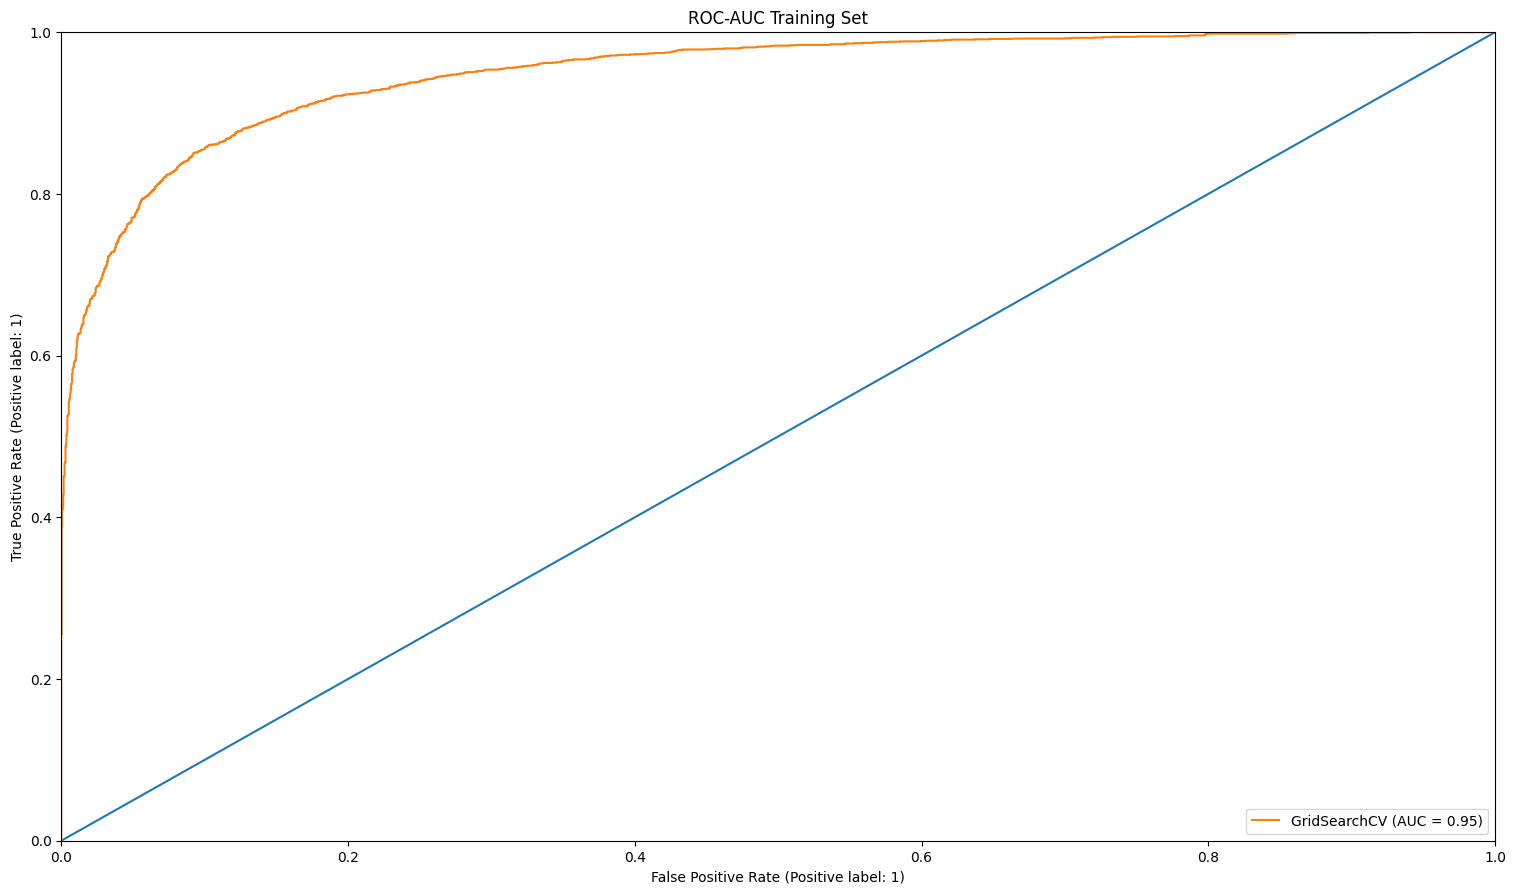

In [34]:
model_eval(xgboost_clf, x_train, y_train, "xgboost_rocauc")

In [36]:
def create_validation(x, y, clf, key, values):
    train_scores_list, test_scores_list = [], []
    key2 = key.split("__")[1]
    
    params = clf.best_params_
    m_params = {}
    for k, v in clf.best_params_.items():
        m_params[k.split("__")[1]] = v
    del m_params[key2]    
    model = XGBClassifier(scale_pos_weight=target_ratio, eval_metric='auc', seed=42, objective='binary:logistic', **m_params)
    pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('xgboost', model),])  
    train_scores, test_scores = vc(
        estimator=pipeline,
        X=x,
        y=y,
        param_name=key,
        param_range=values,
        scoring="roc_auc",
        verbose=0    
    )
    train_scores_list.append(train_scores)
    test_scores_list.append(test_scores)
    
    return train_scores_list, test_scores_list

### Tree Depth Validation

In [37]:
xgboost_train_scores_tree_depth, xgboost_test_scores_tree_depth = create_validation(x_train, y_train, xgboost_clf, "xgboost__max_depth", [3, 4, 5])

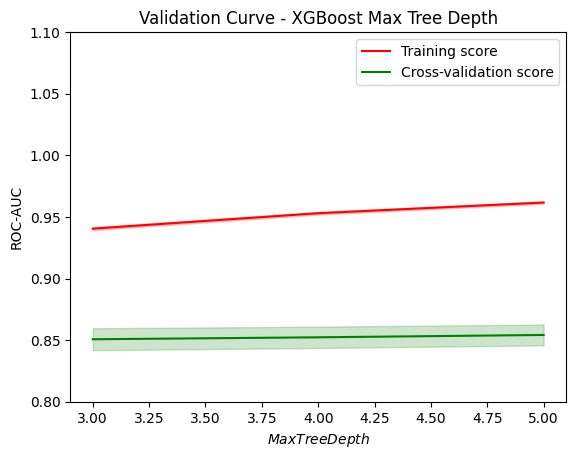

In [38]:
xgboost_train_scores_mean_tree_depth = np.mean(xgboost_train_scores_tree_depth[0], axis=1)
xgboost_train_scores_std_tree_depth = np.std(xgboost_train_scores_tree_depth[0], axis=1)
xgboost_test_scores_mean_tree_depth = np.mean(xgboost_test_scores_tree_depth[0], axis=1)
xgboost_test_scores_std_tree_depth = np.std(xgboost_test_scores_tree_depth[0], axis=1)
xgboost_param_range_tree_depth = np.array([3, 4, 5])

plt.title("Validation Curve - XGBoost Max Tree Depth")
plt.xlabel("$Max Tree Depth$")
plt.ylabel("ROC-AUC")
plt.ylim(0.8, 1.1)
plt.plot(xgboost_param_range_tree_depth, xgboost_train_scores_mean_tree_depth, label="Training score", color="r")
plt.fill_between(xgboost_param_range_tree_depth, xgboost_train_scores_mean_tree_depth - xgboost_train_scores_std_tree_depth,
                 xgboost_train_scores_mean_tree_depth + xgboost_train_scores_std_tree_depth, alpha=0.2, color="r")
plt.plot(xgboost_param_range_tree_depth, xgboost_test_scores_mean_tree_depth, label="Cross-validation score",
             color="g")
plt.fill_between(xgboost_param_range_tree_depth, xgboost_test_scores_mean_tree_depth - xgboost_test_scores_std_tree_depth,
                 xgboost_test_scores_mean_tree_depth + xgboost_test_scores_std_tree_depth, alpha=0.2, color="g")
plt.legend(loc="best")
plt.savefig("xgboost_maxtreedepth")

### XGBoost Min Child Weight

In [40]:
xgboost_train_scores_min_child_weight, xgboost_test_scores_min_child_weight = create_validation(x_train, y_train, xgboost_clf, "xgboost__min_child_weight", [1, 5, 10, 25])

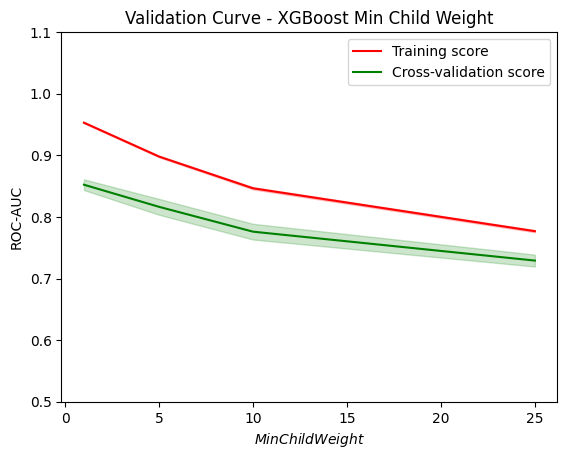

In [45]:
xgboost_train_scores_mean_min_child_weight = np.mean(xgboost_train_scores_min_child_weight[0], axis=1)
xgboost_train_scores_std_min_child_weight = np.std(xgboost_train_scores_min_child_weight[0], axis=1)
xgboost_test_scores_mean_min_child_weight = np.mean(xgboost_test_scores_min_child_weight[0], axis=1)
xgboost_test_scores_std_min_child_weight = np.std(xgboost_test_scores_min_child_weight[0], axis=1)
xgboost_param_range_min_child_weight = np.array([1, 5, 10, 25])

plt.title("Validation Curve - XGBoost Min Child Weight")
plt.xlabel("$Min Child Weight$")
plt.ylabel("ROC-AUC")
plt.ylim(0.5, 1.1)
plt.plot(xgboost_param_range_min_child_weight, xgboost_train_scores_mean_min_child_weight, label="Training score", color="r")
plt.fill_between(xgboost_param_range_min_child_weight, xgboost_train_scores_mean_min_child_weight - xgboost_train_scores_std_min_child_weight,
                 xgboost_train_scores_mean_min_child_weight + xgboost_train_scores_std_min_child_weight, alpha=0.2, color="r")
plt.plot(xgboost_param_range_min_child_weight, xgboost_test_scores_mean_min_child_weight, label="Cross-validation score",
             color="g")
plt.fill_between(xgboost_param_range_min_child_weight, xgboost_test_scores_mean_min_child_weight - xgboost_test_scores_std_min_child_weight,
                 xgboost_test_scores_mean_min_child_weight + xgboost_test_scores_std_min_child_weight, alpha=0.2, color="g")
plt.legend(loc="best")
plt.savefig("xgboost_minchildweight")

### XGBoost Col Sample Used

In [43]:
xgboost_train_scores_colsample_bytree, xgboost_test_scores_colsample_bytree = create_validation(x_train, y_train, xgboost_clf, "xgboost__colsample_bytree", [0.3, 0.4, 0.5 , 0.6, 0.7, 0.8])

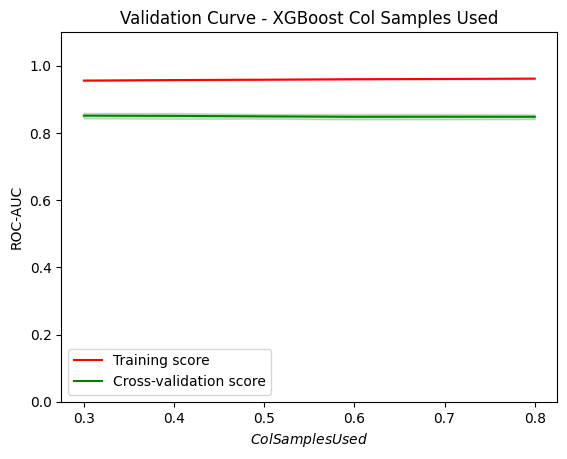

In [44]:
xgboost_train_scores_mean_colsample_bytree = np.mean(xgboost_train_scores_colsample_bytree[0], axis=1)
xgboost_train_scores_std_colsample_bytree = np.std(xgboost_train_scores_colsample_bytree[0], axis=1)
xgboost_test_scores_mean_colsample_bytree = np.mean(xgboost_test_scores_colsample_bytree[0], axis=1)
xgboost_test_scores_std_colsample_bytree = np.std(xgboost_test_scores_colsample_bytree[0], axis=1)
xgboost_param_range_colsample_bytree = np.array([0.3, 0.4, 0.5 , 0.6, 0.7, 0.8])

plt.title("Validation Curve - XGBoost Col Samples Used")
plt.xlabel("$Col Samples Used$")
plt.ylabel("ROC-AUC")
plt.ylim(0.0, 1.1)
plt.plot(xgboost_param_range_colsample_bytree, xgboost_train_scores_mean_colsample_bytree, label="Training score", color="r")
plt.fill_between(xgboost_param_range_colsample_bytree, xgboost_train_scores_mean_colsample_bytree - xgboost_train_scores_std_colsample_bytree,
                 xgboost_train_scores_mean_colsample_bytree + xgboost_train_scores_std_colsample_bytree, alpha=0.2, color="r")
plt.plot(xgboost_param_range_colsample_bytree, xgboost_test_scores_mean_colsample_bytree, label="Cross-validation score",
             color="g")
plt.fill_between(xgboost_param_range_colsample_bytree, xgboost_test_scores_mean_colsample_bytree - xgboost_test_scores_std_colsample_bytree,
                 xgboost_test_scores_mean_colsample_bytree + xgboost_test_scores_std_colsample_bytree, alpha=0.2, color="g")
plt.legend(loc="best")
plt.savefig("xgboost_colused")

### XGBoost Row Samples Used

In [46]:
xgboost_train_scores_subsample, xgboost_test_scores_subsample = create_validation(x_train, y_train, xgboost_clf, "xgboost__subsample", [0.25, 0.5, 1.0])

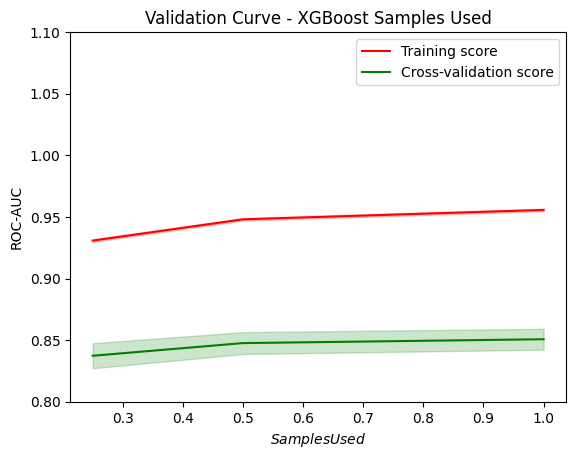

In [47]:
xgboost_train_scores_mean_subsample = np.mean(xgboost_train_scores_subsample[0], axis=1)
xgboost_train_scores_std_subsample = np.std(xgboost_train_scores_subsample[0], axis=1)
xgboost_test_scores_mean_subsample = np.mean(xgboost_test_scores_subsample[0], axis=1)
xgboost_test_scores_std_subsample = np.std(xgboost_test_scores_subsample[0], axis=1)
xgboost_param_range_subsample = np.array([0.25, 0.5, 1.0])

plt.title("Validation Curve - XGBoost Samples Used")
plt.xlabel("$Samples Used$")
plt.ylabel("ROC-AUC")
plt.ylim(0.8, 1.1)
plt.plot(xgboost_param_range_subsample, xgboost_train_scores_mean_subsample, label="Training score", color="r")
plt.fill_between(xgboost_param_range_subsample, xgboost_train_scores_mean_subsample - xgboost_train_scores_std_subsample,
                 xgboost_train_scores_mean_subsample + xgboost_train_scores_std_subsample, alpha=0.2, color="r")
plt.plot(xgboost_param_range_subsample, xgboost_test_scores_mean_subsample, label="Cross-validation score",
             color="g")
plt.fill_between(xgboost_param_range_subsample, xgboost_test_scores_mean_subsample - xgboost_test_scores_std_subsample,
                 xgboost_test_scores_mean_subsample + xgboost_test_scores_std_subsample, alpha=0.2, color="g")
plt.legend(loc="best")
plt.savefig("xgboost_sampleused")

### XGBoost No. Estimators

In [48]:
xgboost_train_scores_n_estimators, xgboost_test_scores_n_estimators = create_validation(x_train, y_train, xgboost_clf, "xgboost__n_estimators", [50, 100, 250, 500, 1000])

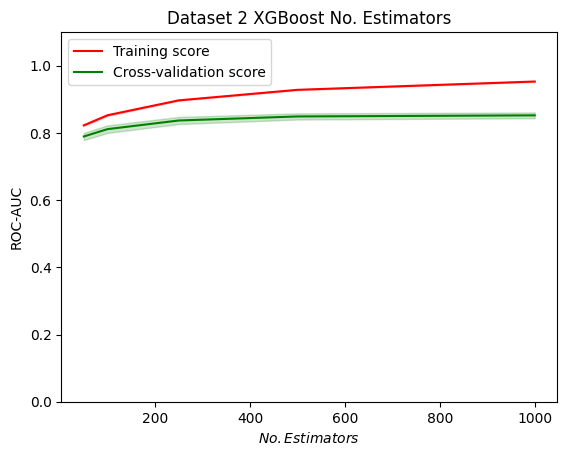

In [17]:
xgboost_train_scores_mean_n_estimators = np.mean(xgboost_train_scores_n_estimators[0], axis=1)
xgboost_train_scores_std_n_estimators = np.std(xgboost_train_scores_n_estimators[0], axis=1)
xgboost_test_scores_mean_n_estimators = np.mean(xgboost_test_scores_n_estimators[0], axis=1)
xgboost_test_scores_std_n_estimators = np.std(xgboost_test_scores_n_estimators[0], axis=1)
xgboost_param_range_n_estimators = np.array([50, 100, 250, 500, 1000])

plt.title("Dataset 2 XGBoost No. Estimators")
plt.xlabel("$No. Estimators$")
plt.ylabel("ROC-AUC")
plt.ylim(0.0, 1.1)
plt.plot(xgboost_param_range_n_estimators, xgboost_train_scores_mean_n_estimators, label="Training score", color="r")
plt.fill_between(xgboost_param_range_n_estimators, xgboost_train_scores_mean_n_estimators - xgboost_train_scores_std_n_estimators,
                 xgboost_train_scores_mean_n_estimators + xgboost_train_scores_std_n_estimators, alpha=0.2, color="r")
plt.plot(xgboost_param_range_n_estimators, xgboost_test_scores_mean_n_estimators, label="Cross-validation score",
             color="g")
plt.fill_between(xgboost_param_range_n_estimators, xgboost_test_scores_mean_n_estimators - xgboost_test_scores_std_n_estimators,
                 xgboost_test_scores_mean_n_estimators + xgboost_test_scores_std_n_estimators, alpha=0.2, color="g")
plt.legend(loc="best")
plt.savefig("xgboost2_estimators")

### XGBoost Learning Rate

In [50]:
xgboost_train_scores_learning_rate, xgboost_test_scores_learning_rate = create_validation(x_train, y_train, xgboost_clf, "xgboost__learning_rate", [0.001, 0.01, 0.1, 1.])

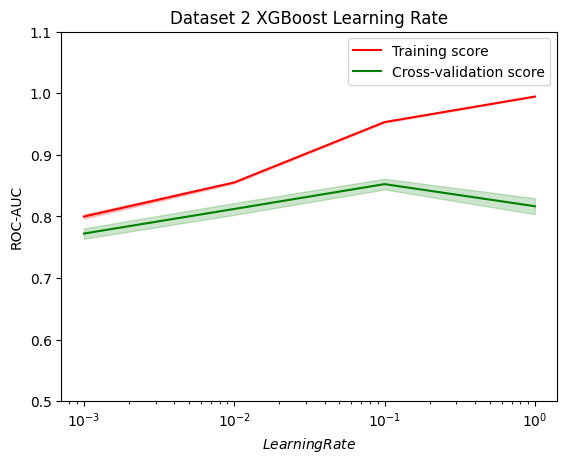

In [18]:
xgboost_train_scores_mean_learning_rate = np.mean(xgboost_train_scores_learning_rate[0], axis=1)
xgboost_train_scores_std_learning_rate = np.std(xgboost_train_scores_learning_rate[0], axis=1)
xgboost_test_scores_mean_learning_rate = np.mean(xgboost_test_scores_learning_rate[0], axis=1)
xgboost_test_scores_std_learning_rate = np.std(xgboost_test_scores_learning_rate[0], axis=1)
xgboost_param_range_learning_rate = np.array([0.001, 0.01, 0.1, 1.])

plt.title("Dataset 2 XGBoost Learning Rate")
plt.xlabel("$Learning Rate$")
plt.ylabel("ROC-AUC")
plt.ylim(0.5, 1.1)
plt.semilogx(xgboost_param_range_learning_rate, xgboost_train_scores_mean_learning_rate, label="Training score", color="r")
plt.fill_between(xgboost_param_range_learning_rate, xgboost_train_scores_mean_learning_rate - xgboost_train_scores_std_learning_rate,
                 xgboost_train_scores_mean_learning_rate + xgboost_train_scores_std_learning_rate, alpha=0.2, color="r")
plt.semilogx(xgboost_param_range_learning_rate, xgboost_test_scores_mean_learning_rate, label="Cross-validation score",
             color="g")
plt.fill_between(xgboost_param_range_learning_rate, xgboost_test_scores_mean_learning_rate - xgboost_test_scores_std_learning_rate,
                 xgboost_test_scores_mean_learning_rate + xgboost_test_scores_std_learning_rate, alpha=0.2, color="g")
plt.legend(loc="best")
plt.savefig("xgboost2_learningrate")

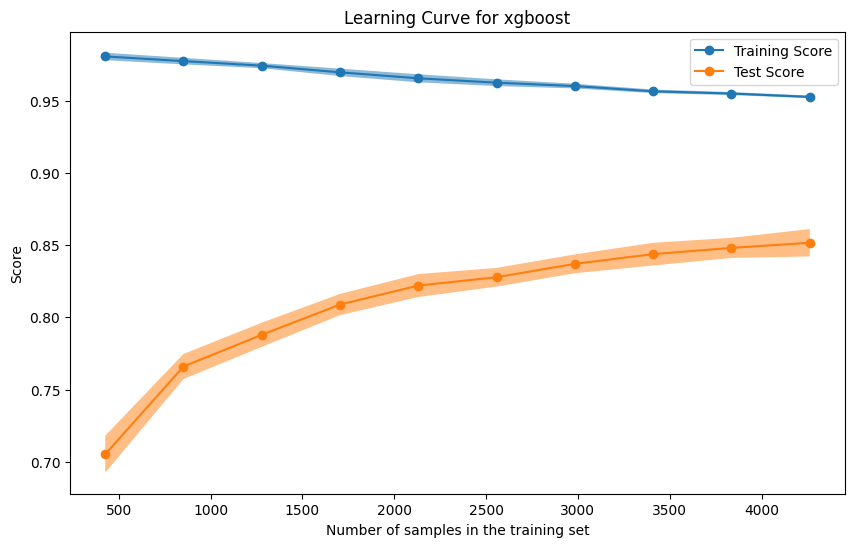

In [7]:
learning_curve(xgboost_clf.best_estimator_, "xgboost")

# Decision Tree Model

In [52]:
model = DecisionTreeClassifier(class_weight='balanced')
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('decision_tree', model),
])
path = pipeline[-1].cost_complexity_pruning_path(
    pipeline[:-1].fit_transform(x_train),
    y_train,
)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
ccp_alphas_filtered = [ccp_alphas[i] for i in range(0, len(ccp_alphas), len(ccp_alphas)//5)]
parameters = {
    "decision_tree__ccp_alpha" : ccp_alphas_filtered,
    "decision_tree__min_samples_split": [2, 5, 20, 100],
    "decision_tree__min_samples_leaf": [1, 5, 20, 100],
    "decision_tree__max_features": [None, "log2", "sqrt"]
}
skf = StratifiedKFold(n_splits=5)
dt_clf = GridSearchCV(pipeline, param_grid = parameters, cv = skf, scoring= 'roc_auc', verbose=1, n_jobs=-1, error_score='raise', return_train_score=True)
dt_clf.fit(x_train,y_train)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise',
             estimator=Pipeline(steps=[('bow', CountVectorizer()),
                                       ('decision_tree',
                                        DecisionTreeClassifier(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'decision_tree__ccp_alpha': [0.0,
                                                      2.1331796106334978e-17,
                                                      0.0002478528400702612,
                                                      0.0003166274651709729,
                                                      0.0005568317465097653],
                         'decision_tree__max_features': [None, 'log2', 'sqrt'],
                         'decision_tree__min_samples_leaf': [1, 5, 20, 100],
                         'decision_tree__min_samples_split': [2, 5, 20, 100]},
             return_train_score=True, scoring='roc_auc', verbose=1)

Best score (CV score=0.771):
{'decision_tree__ccp_alpha': 0.0005461876142388701, 'decision_tree__max_features': None, 'decision_tree__min_samples_leaf': 1, 'decision_tree__min_samples_split': 5}
Best Results: {'decision_tree__ccp_alpha': 0.0005461876142388701, 'decision_tree__max_features': None, 'decision_tree__min_samples_leaf': 1, 'decision_tree__min_samples_split': 5}


mean_fit_time : 1.3846294403076171
std_fit_time : 0.04990972541717979
mean_score_time : 0.034779024124145505
std_score_time : 0.0008070294210664752
param_decision_tree__ccp_alpha : 0.0005461876142388701
param_decision_tree__max_features : None
param_decision_tree__min_samples_leaf : 1
param_decision_tree__min_samples_split : 5
params : {'decision_tree__ccp_alpha': 0.0005461876142388701, 'decision_tree__max_features': None, 'decision_tree__min_samples_leaf': 1, 'decision_tree__min_samples_split': 5}
split0_test_score : 0.7682213858883016
split1_test_score : 0.7822052401746724
split2_test_score : 0.7662749942541945
sp

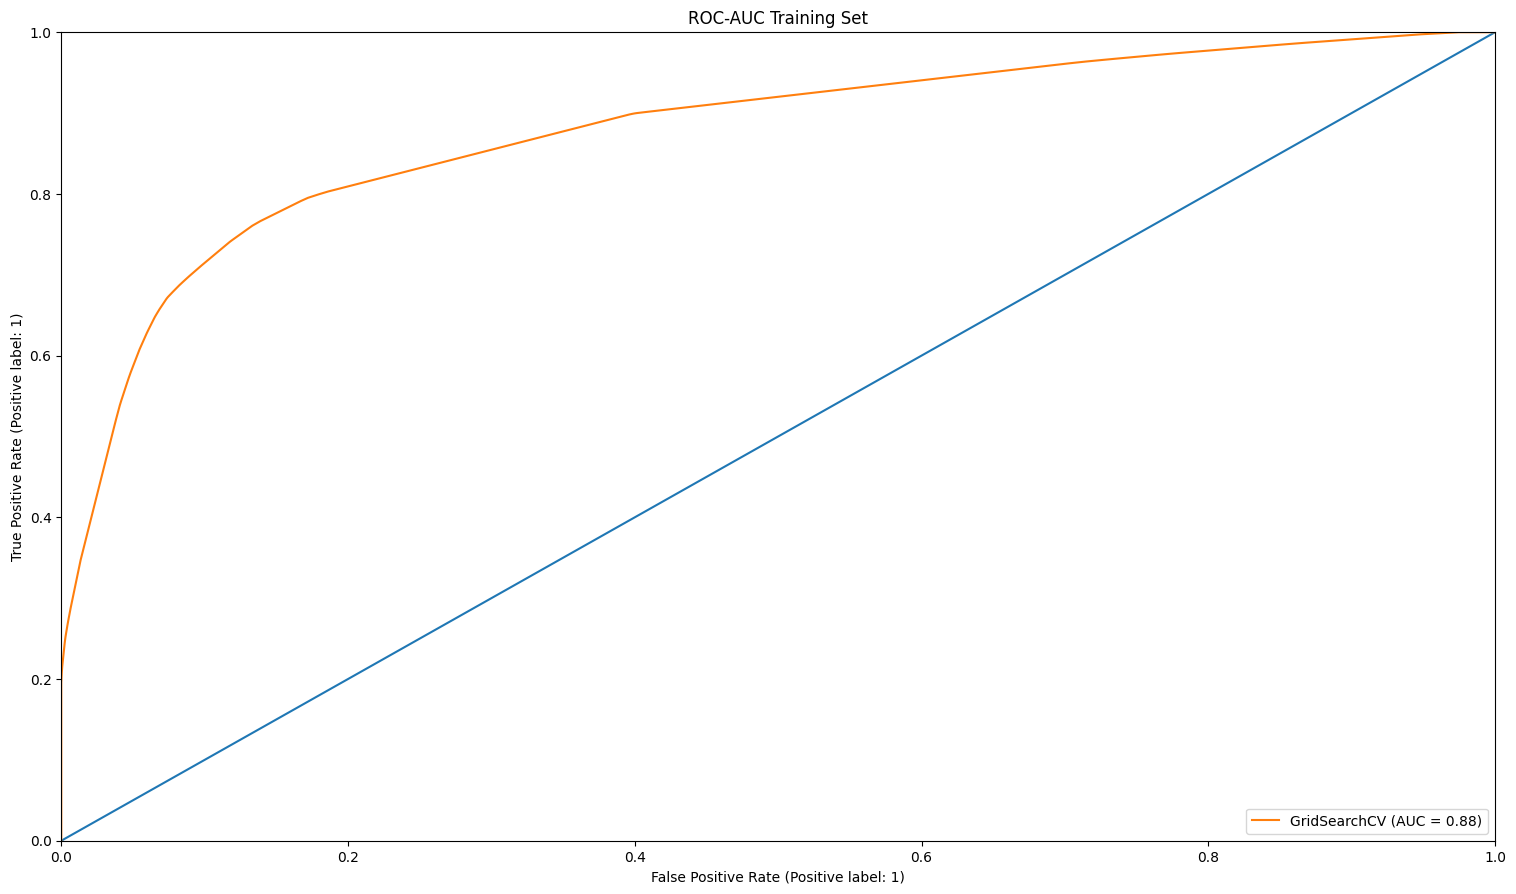

In [52]:
model_eval(dt_clf, x_train, y_train, "decision_tree2")

In [3]:
def create_validation_dt(x, y, clf, key, values):
    train_scores_list, test_scores_list = [], []
    key2 = key.split("__")[1]
    
    params = clf.best_params_
    m_params = {}
    for k, v in clf.best_params_.items():
        m_params[k.split("__")[1]] = v
    del m_params[key2]    
    model = DecisionTreeClassifier(class_weight='balanced', **m_params)
    pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('decision_tree', model),])
    train_scores, test_scores = vc(
        estimator=pipeline,
        X=x,
        y=y,
        param_name=key,
        param_range=values,
        scoring="roc_auc",
        verbose=0    
    )
    train_scores_list.append(train_scores)
    test_scores_list.append(test_scores)
    
    return train_scores_list, test_scores_list

### Decision Tree Post Pruning Alpha

In [4]:
dt_train_scores_alpha, dt_test_scores_alpha = create_validation_dt(x_train, y_train, dt_clf, "decision_tree__ccp_alpha", ccp_alphas_filtered)

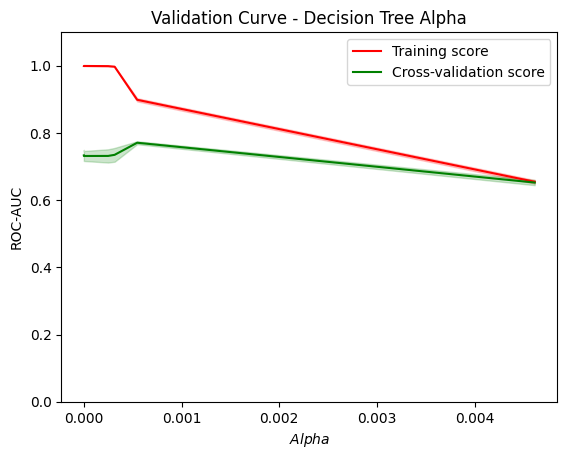

In [6]:
dt_train_scores_mean_alpha = np.mean(dt_train_scores_alpha[0], axis=1)
dt_train_scores_std_alpha = np.std(dt_train_scores_alpha[0], axis=1)
dt_test_scores_mean_alpha = np.mean(dt_test_scores_alpha[0], axis=1)
dt_test_scores_std_alpha = np.std(dt_test_scores_alpha[0], axis=1)
dt_param_range_alpha = np.array(ccp_alphas_filtered)

plt.title("Validation Curve - Decision Tree Alpha")
plt.xlabel("$Alpha$")
plt.ylabel("ROC-AUC")
plt.ylim(0.0, 1.1)
plt.plot(dt_param_range_alpha, dt_train_scores_mean_alpha, label="Training score", color="r")
plt.fill_between(dt_param_range_alpha, dt_train_scores_mean_alpha - dt_train_scores_std_alpha,
                 dt_train_scores_mean_alpha + dt_train_scores_std_alpha, alpha=0.2, color="r")
plt.plot(dt_param_range_alpha, dt_test_scores_mean_alpha, label="Cross-validation score",
             color="g")
plt.fill_between(dt_param_range_alpha, dt_test_scores_mean_alpha - dt_test_scores_std_alpha,
                 dt_test_scores_mean_alpha + dt_test_scores_std_alpha, alpha=0.2, color="g")
plt.legend(loc="best")
plt.savefig("dt2_alpha")

### Decision Tree Min Samples Split

In [57]:
dt_train_scores_min_samples_split, dt_test_scores_min_samples_split = create_validation_dt(x_train, y_train, dt_clf, "decision_tree__min_samples_split", [2, 5, 20, 100])

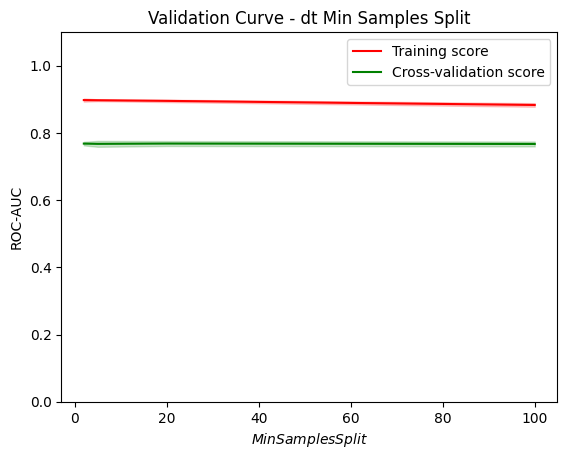

In [58]:
dt_train_scores_mean_min_samples_split = np.mean(dt_train_scores_min_samples_split[0], axis=1)
dt_train_scores_std_min_samples_split = np.std(dt_train_scores_min_samples_split[0], axis=1)
dt_test_scores_mean_min_samples_split = np.mean(dt_test_scores_min_samples_split[0], axis=1)
dt_test_scores_std_min_samples_split = np.std(dt_test_scores_min_samples_split[0], axis=1)
dt_param_range_min_samples_split = np.array([2, 5, 20, 100])

plt.title("Validation Curve - dt Min Samples Split")
plt.xlabel("$Min Samples Split$")
plt.ylabel("ROC-AUC")
plt.ylim(0.0, 1.1)
plt.plot(dt_param_range_min_samples_split, dt_train_scores_mean_min_samples_split, label="Training score", color="r")
plt.fill_between(dt_param_range_min_samples_split, dt_train_scores_mean_min_samples_split - dt_train_scores_std_min_samples_split,
                 dt_train_scores_mean_min_samples_split + dt_train_scores_std_min_samples_split, alpha=0.2, color="r")
plt.plot(dt_param_range_min_samples_split, dt_test_scores_mean_min_samples_split, label="Cross-validation score",
             color="g")
plt.fill_between(dt_param_range_min_samples_split, dt_test_scores_mean_min_samples_split - dt_test_scores_std_min_samples_split,
                 dt_test_scores_mean_min_samples_split + dt_test_scores_std_min_samples_split, alpha=0.2, color="g")
plt.legend(loc="best")
plt.savefig("dt2_min_sample_split")

### Decision Tree Min Samples Leaf

In [59]:
dt_train_scores_min_samples_leaf, dt_test_scores_min_samples_leaf = create_validation_dt(x_train, y_train, dt_clf, "decision_tree__min_samples_leaf", [1, 2, 5, 20, 100])    

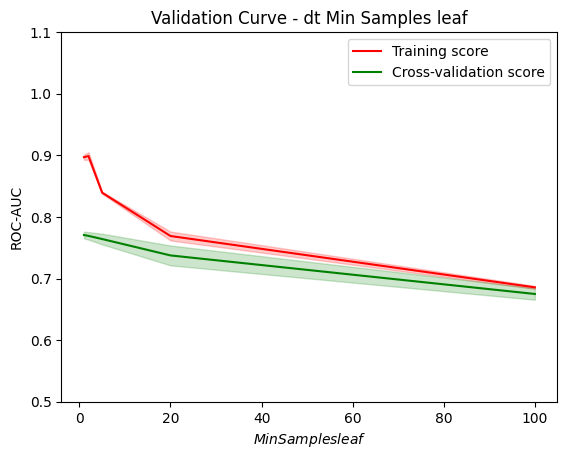

In [62]:
dt_train_scores_mean_min_samples_leaf = np.mean(dt_train_scores_min_samples_leaf[0], axis=1)
dt_train_scores_std_min_samples_leaf = np.std(dt_train_scores_min_samples_leaf[0], axis=1)
dt_test_scores_mean_min_samples_leaf = np.mean(dt_test_scores_min_samples_leaf[0], axis=1)
dt_test_scores_std_min_samples_leaf = np.std(dt_test_scores_min_samples_leaf[0], axis=1)
dt_param_range_min_samples_leaf = np.array([1, 2, 5, 20, 100])

plt.title("Validation Curve - dt Min Samples leaf")
plt.xlabel("$Min Samples leaf$")
plt.ylabel("ROC-AUC")
plt.ylim(0.5, 1.1)
plt.plot(dt_param_range_min_samples_leaf, dt_train_scores_mean_min_samples_leaf, label="Training score", color="r")
plt.fill_between(dt_param_range_min_samples_leaf, dt_train_scores_mean_min_samples_leaf - dt_train_scores_std_min_samples_leaf,
                 dt_train_scores_mean_min_samples_leaf + dt_train_scores_std_min_samples_leaf, alpha=0.2, color="r")
plt.plot(dt_param_range_min_samples_leaf, dt_test_scores_mean_min_samples_leaf, label="Cross-validation score",
             color="g")
plt.fill_between(dt_param_range_min_samples_leaf, dt_test_scores_mean_min_samples_leaf - dt_test_scores_std_min_samples_leaf,
                 dt_test_scores_mean_min_samples_leaf + dt_test_scores_std_min_samples_leaf, alpha=0.2, color="g")
plt.legend(loc="best")
plt.show()

### Decision Tree Max Features

In [8]:
dt_train_scores_max_features, dt_test_scores_max_features = create_validation_dt(x_train, y_train, dt_clf, "decision_tree__max_features", ["log2", "sqrt", None])

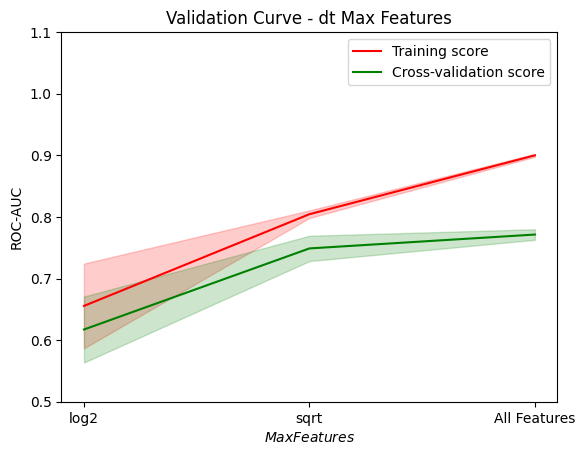

In [10]:
dt_train_scores_mean_max_features = np.mean(dt_train_scores_max_features[0], axis=1)
dt_train_scores_std_max_features = np.std(dt_train_scores_max_features[0], axis=1)
dt_test_scores_mean_max_features = np.mean(dt_test_scores_max_features[0], axis=1)
dt_test_scores_std_max_features = np.std(dt_test_scores_max_features[0], axis=1)
dt_param_range_max_features = np.array(["log2", "sqrt", "All Features"])

plt.title("Validation Curve - dt Max Features")
plt.xlabel("$Max Features$")
plt.ylabel("ROC-AUC")
plt.ylim(0.5, 1.1)
plt.plot(dt_param_range_max_features, dt_train_scores_mean_max_features, label="Training score", color="r")
plt.fill_between(dt_param_range_max_features, dt_train_scores_mean_max_features - dt_train_scores_std_max_features,
                 dt_train_scores_mean_max_features + dt_train_scores_std_max_features, alpha=0.2, color="r")
plt.plot(dt_param_range_max_features, dt_test_scores_mean_max_features, label="Cross-validation score",
             color="g")
plt.fill_between(dt_param_range_max_features, dt_test_scores_mean_max_features - dt_test_scores_std_max_features,
                 dt_test_scores_mean_max_features + dt_test_scores_std_max_features, alpha=0.2, color="g")
plt.legend(loc="best")
plt.savefig("dt2_max_features")

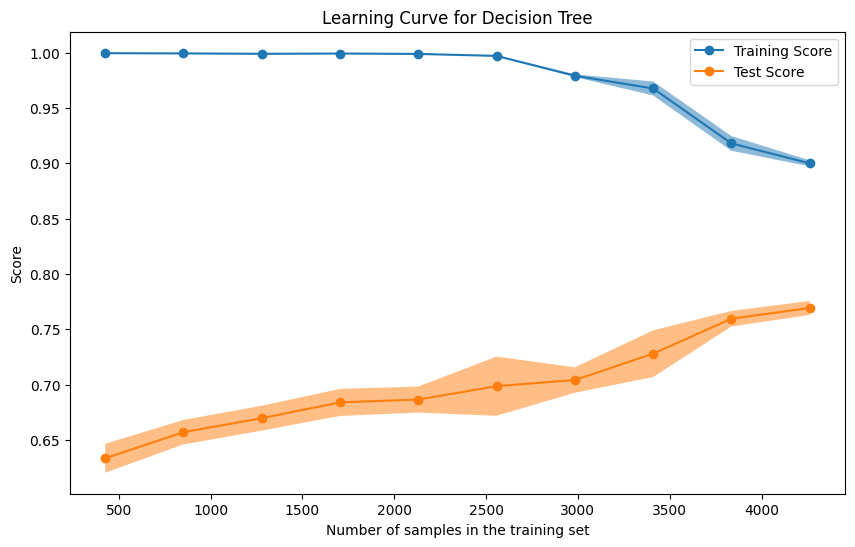

In [6]:
learning_curve(dt_clf.best_estimator_, "Decision Tree")

# Neural Network Model

In [9]:
vect = CountVectorizer()
vect.fit(x_train)
print(len(vect.get_feature_names_out()))
n_features = len(vect.get_feature_names_out())

17098


In [10]:
model = MLPClassifier(max_iter=500)
sqrt_n_features = int(math.sqrt(n_features))
sqrt_sqrt_n_features = int(math.sqrt(sqrt_n_features))
log2_n_features = int(math.log2(n_features))
log2_log2_n_features = int(math.log2(log2_n_features))  
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('mlp', model),
])
parameters = {
    "mlp__hidden_layer_sizes"    : [(sqrt_n_features,), (log2_n_features,), (sqrt_n_features, sqrt_sqrt_n_features), (log2_n_features, log2_log2_n_features)],
    "mlp__activation": ["logistic", "relu", "tanh"],
    "mlp__alpha": [0.0001, 0.001, 0.01, 0.1]
}
skf = StratifiedKFold(n_splits=5)
mlp_clf = GridSearchCV(pipeline, param_grid = parameters, cv = skf, scoring= 'roc_auc', verbose=3, n_jobs=-1, error_score='raise', return_train_score=True)
mlp_clf.fit(x_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END mlp__activation=logistic, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(130,);, score=(train=1.000, test=0.848) total time= 4.5min
[CV 5/5] END mlp__activation=logistic, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(130,);, score=(train=1.000, test=0.813) total time= 4.1min
[CV 4/5] END mlp__activation=logistic, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(130, 11);, score=(train=1.000, test=0.841) total time= 4.4min
[CV 5/5] END mlp__activation=logistic, mlp__alpha=0.0001, mlp__hidden_layer_sizes=(14, 3);, score=(train=1.000, test=0.819) total time= 1.3min
[CV 3/5] END mlp__activation=logistic, mlp__alpha=0.001, mlp__hidden_layer_sizes=(130,);, score=(train=1.000, test=0.853) total time= 8.1min
[CV 2/5] END mlp__activation=logistic, mlp__alpha=0.001, mlp__hidden_layer_sizes=(14,);, score=(train=1.000, test=0.842) total time= 1.1min
[CV 5/5] END mlp__activation=logistic, mlp__alpha=0.001, mlp__hidden_layer_sizes=(14,);, score=(train=1.000, test=0.820) total time=  57.6s
[CV 2/5

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise',
             estimator=Pipeline(steps=[('bow', CountVectorizer()),
                                       ('mlp', MLPClassifier(max_iter=500))]),
             n_jobs=-1,
             param_grid={'mlp__activation': ['logistic', 'relu', 'tanh'],
                         'mlp__alpha': [0.0001, 0.001, 0.01, 0.1],
                         'mlp__hidden_layer_sizes': [(130,), (14,), (130, 11),
                                                     (14, 3)]},
             return_train_score=True, scoring='roc_auc', verbose=3)

Best score (CV score=0.848):
{'mlp__activation': 'logistic', 'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': (130,)}
Best Results: {'mlp__activation': 'logistic', 'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': (130,)}


mean_fit_time : 571.5589341163635
std_fit_time : 80.42848976617454
mean_score_time : 0.058618593215942386
std_score_time : 0.00099026740981267
param_mlp__activation : logistic
param_mlp__alpha : 0.1
param_mlp__hidden_layer_sizes : (130,)
params : {'mlp__activation': 'logistic', 'mlp__alpha': 0.1, 'mlp__hidden_layer_sizes': (130,)}
split0_test_score : 0.8477774505860721
split1_test_score : 0.8494401430705586
split2_test_score : 0.8611795420592968
split3_test_score : 0.8507975896345668
split4_test_score : 0.8311259469220089
mean_test_score : 0.8480641344545006
std_test_score : 0.009678465561225254
rank_test_score : 1
split0_train_score : 0.9999006419986385
split1_train_score : 0.9999291583063737
split2_train_score : 0.9999142265389376
split3_train_score : 0.999933087718857
s

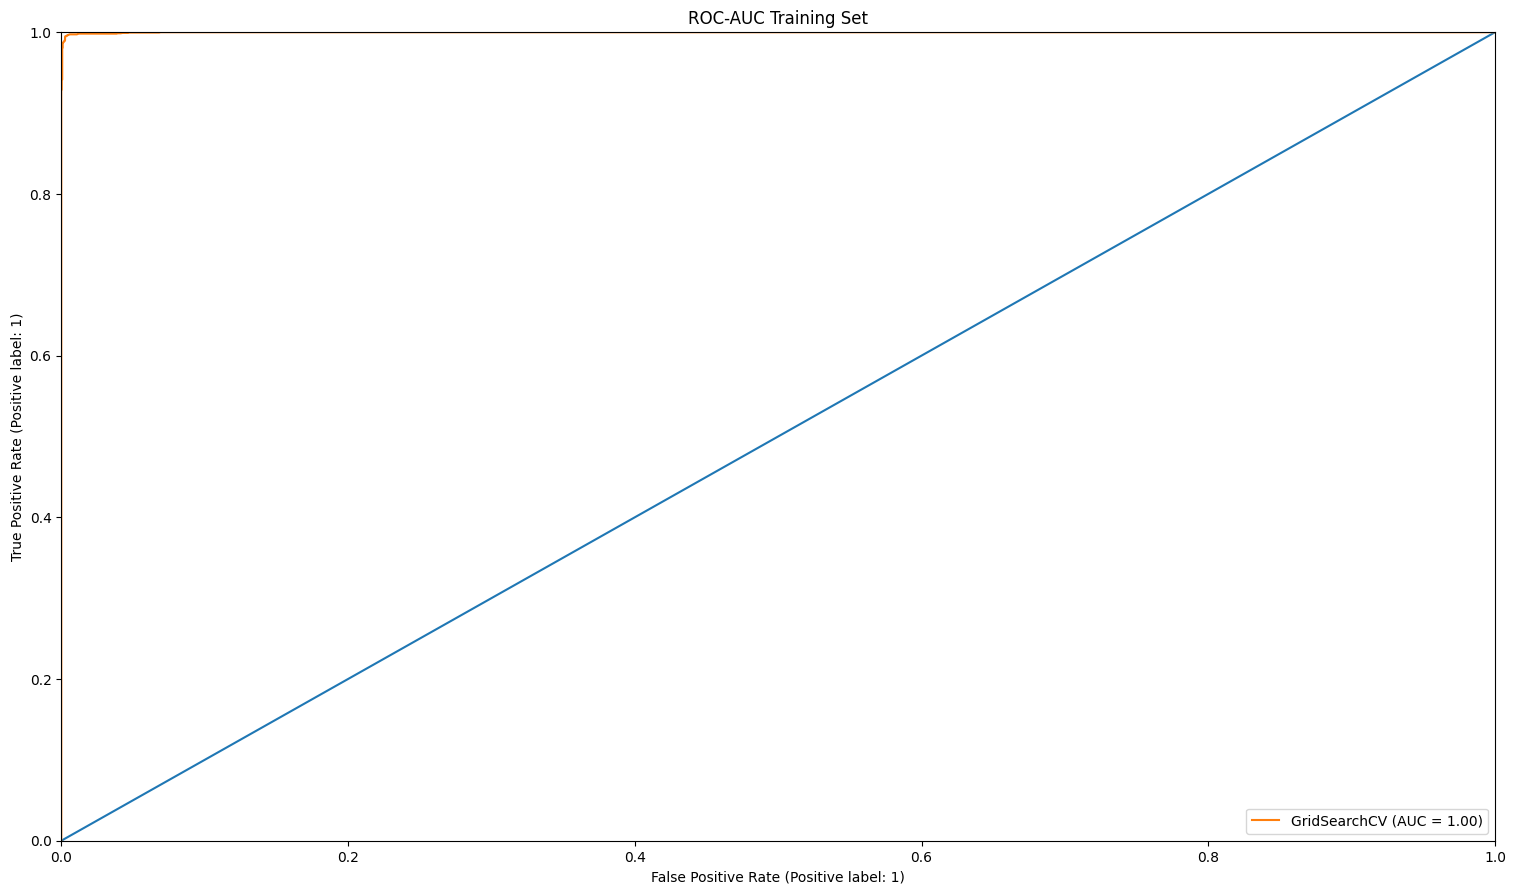

In [1]:
model_eval(mlp_clf, x_train, y_train, "mlp2_rocauc")

In [12]:
def create_validation_mlp(x, y, clf, key, values):
    train_scores_list, test_scores_list = [], []
    key2 = key.split("__")[1]
    
    params = clf.best_params_
    m_params = {}
    for k, v in clf.best_params_.items():
        m_params[k.split("__")[1]] = v
    del m_params[key2]    
    model = MLPClassifier(max_iter=500, **m_params)
    pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('mlp', model),])   
    train_scores, test_scores = vc(
        estimator=pipeline,
        X=x,
        y=y,
        param_name=key,
        param_range=values,
        scoring="roc_auc",
        verbose=0    
    )
    train_scores_list.append(train_scores)
    test_scores_list.append(test_scores)
    
    return train_scores_list, test_scores_list

### MLP Hidden Layer Size

In [53]:
mlp_train_scores_hidden_layer_size, mlp_test_scores_hidden_layer_size = create_validation_mlp(x_train, y_train, mlp_clf, "mlp__hidden_layer_sizes",  [(sqrt_n_features,), (log2_n_features,), (sqrt_n_features, sqrt_sqrt_n_features), (log2_n_features, log2_log2_n_features)])

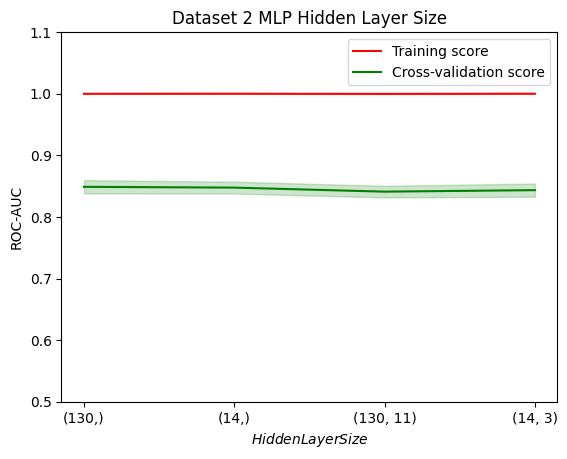

In [19]:
mlp_train_scores_mean_hidden_layer_size = np.mean(mlp_train_scores_hidden_layer_size[0], axis=1)
mlp_train_scores_std_hidden_layer_size = np.std(mlp_train_scores_hidden_layer_size[0], axis=1)
mlp_test_scores_mean_hidden_layer_size = np.mean(mlp_test_scores_hidden_layer_size[0], axis=1)
mlp_test_scores_std_hidden_layer_size = np.std(mlp_test_scores_hidden_layer_size[0], axis=1)
mlp_param_range_hidden_layer_size = np.array([f"{(sqrt_n_features,)}", f"{(log2_n_features,)}", f"{(sqrt_n_features, sqrt_sqrt_n_features)}", f"{(log2_n_features, log2_log2_n_features)}"])

plt.title("Dataset 2 MLP Hidden Layer Size")
plt.xlabel("$Hidden Layer Size$")
plt.ylabel("ROC-AUC")
plt.ylim(0.5, 1.1)
plt.plot(mlp_param_range_hidden_layer_size, mlp_train_scores_mean_hidden_layer_size, label="Training score", color="r")
plt.fill_between(mlp_param_range_hidden_layer_size, mlp_train_scores_mean_hidden_layer_size - mlp_train_scores_std_hidden_layer_size,
                 mlp_train_scores_mean_hidden_layer_size + mlp_train_scores_std_hidden_layer_size, alpha=0.2, color="r")
plt.plot(mlp_param_range_hidden_layer_size, mlp_test_scores_mean_hidden_layer_size, label="Cross-validation score",
             color="g")
plt.fill_between(mlp_param_range_hidden_layer_size, mlp_test_scores_mean_hidden_layer_size - mlp_test_scores_std_hidden_layer_size,
                 mlp_test_scores_mean_hidden_layer_size + mlp_test_scores_std_hidden_layer_size, alpha=0.2, color="g")
plt.legend(loc="best")
plt.savefig("mlp2_hiddenlayer")

### MLP Activation

In [55]:
mlp_train_scores_activation, mlp_test_scores_activation = create_validation_mlp(x_train, y_train, mlp_clf, "mlp__activation",  ["logistic", "relu", "tanh"])

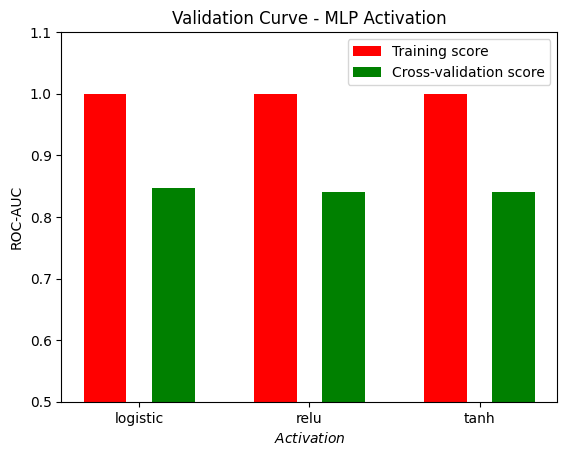

In [56]:
mlp_train_scores_mean_activation = np.mean(mlp_train_scores_activation[0], axis=1)
mlp_train_scores_std_activation = np.std(mlp_train_scores_activation[0], axis=1)
mlp_test_scores_mean_activation = np.mean(mlp_test_scores_activation[0], axis=1)
mlp_test_scores_std_activation = np.std(mlp_test_scores_activation[0], axis=1)
mlp_param_range_activation = np.array(["logistic", "relu", "tanh"])

plt.title("Validation Curve - MLP Activation")
plt.xlabel("$Activation$")
plt.ylabel("ROC-AUC")
plt.ylim(0.5, 1.1)
width = 0.2
_X = np.arange(len(mlp_param_range_activation))
plt.bar(_X - width, mlp_train_scores_mean_activation, width=0.25, label="Training score", color="r")
plt.bar(_X + width, mlp_test_scores_mean_activation, width=0.25, label="Cross-validation score",
             color="g")
plt.legend(loc="best")
plt.xticks(_X, mlp_param_range_activation) # set labels manually
plt.savefig("mlp2_activation")

### MLP Alpha

In [57]:
mlp_train_scores_alpha, mlp_test_scores_alpha = create_validation_mlp(x_train, y_train, mlp_clf, "mlp__alpha",  [0.0001, 0.001, 0.01, 0.1])

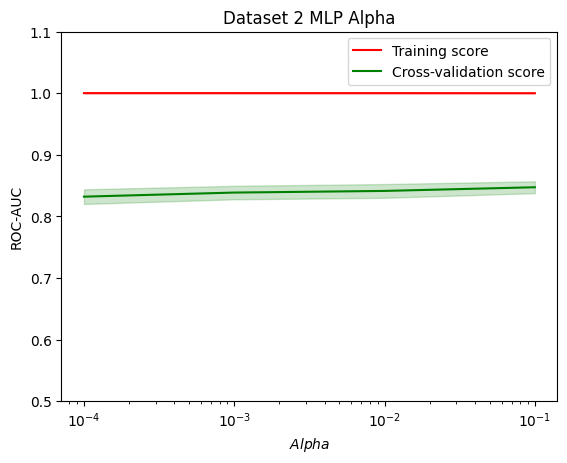

In [20]:
mlp_train_scores_mean_alpha = np.mean(mlp_train_scores_alpha[0], axis=1)
mlp_train_scores_std_alpha = np.std(mlp_train_scores_alpha[0], axis=1)
mlp_test_scores_mean_alpha = np.mean(mlp_test_scores_alpha[0], axis=1)
mlp_test_scores_std_alpha = np.std(mlp_test_scores_alpha[0], axis=1)
mlp_param_range_alpha = np.array([0.0001, 0.001, 0.01, 0.1])

plt.title("Dataset 2 MLP Alpha")
plt.xlabel("$Alpha$")
plt.ylabel("ROC-AUC")
plt.ylim(0.5, 1.1)
plt.semilogx(mlp_param_range_alpha, mlp_train_scores_mean_alpha, label="Training score", color="r")
plt.fill_between(mlp_param_range_alpha, mlp_train_scores_mean_alpha - mlp_train_scores_std_alpha,
                 mlp_train_scores_mean_alpha + mlp_train_scores_std_alpha, alpha=0.2, color="r")
plt.semilogx(mlp_param_range_alpha, mlp_test_scores_mean_alpha, label="Cross-validation score",
             color="g")
plt.fill_between(mlp_param_range_alpha, mlp_test_scores_mean_alpha - mlp_test_scores_std_alpha,
                 mlp_test_scores_mean_alpha + mlp_test_scores_std_alpha, alpha=0.2, color="g")
plt.legend(loc="best")
plt.savefig("mlp2_alpha")

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptro

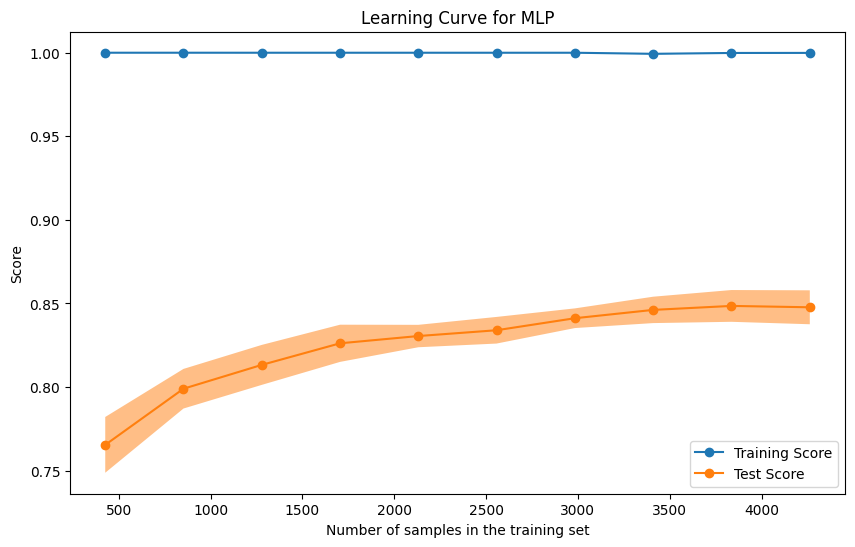

In [60]:
learning_curve(mlp_clf.best_estimator_, "MLP")

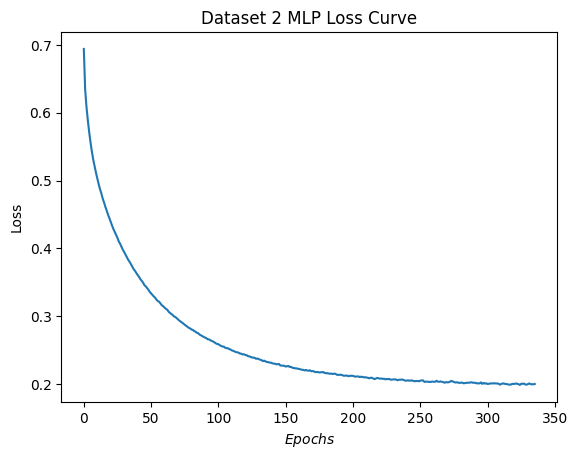

In [2]:
params = {}
for k, v in mlp_clf.best_params_.items():
    params[k.split("__")[1]] = v
model = MLPClassifier(max_iter=500, **params)
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('mlp', model),
])
mlp_model_loss_curve = pipeline.fit(x_train, y_train)
plt.title("Dataset 2 MLP Loss Curve")
plt.xlabel("$Epochs$")
plt.ylabel("Loss")
plt.plot(mlp_model_loss_curve["mlp"].loss_curve_)
plt.savefig("mlp2_losscurve")

# KNN Model

In [1]:
model = KNeighborsClassifier()
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('knn', model),
])
parameters = {
    "knn__n_neighbors" : np.arange(3, 21, 1),
    "knn__p": [2], #Eucldean
    "knn__weights": ["uniform"]
}
skf = StratifiedKFold(n_splits=5)
knn_clf = GridSearchCV(pipeline, param_grid = parameters, cv = skf, scoring= 'roc_auc', verbose=3, n_jobs=-1, error_score='raise', return_train_score=True)
knn_clf.fit(x_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise',
             estimator=Pipeline(steps=[('bow', CountVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [3, 4, 5], 'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance']},
             return_train_score=True, scoring='roc_auc', verbose=2)

Best score (CV score=0.720):
{'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'distance'}
Best Results: {'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'distance'}


mean_fit_time : 0.18635139465332032
std_fit_time : 0.046356086718651525
mean_score_time : 1.2008302688598633
std_score_time : 0.16511787766504035
param_knn__n_neighbors : 3
param_knn__p : 1
param_knn__weights : distance
params : {'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'distance'}
split0_test_score : 0.672837422431625
split1_test_score : 0.7372119914962079
split2_test_score : 0.7360915594116294
split3_test_score : 0.73342694208228
split4_test_score : 0.7191301626583599
mean_test_score : 0.7197396156160204
std_test_score : 0.024331872303631822
rank_test_score : 1
split0_train_score : 0.9999859663839884
split1_train_score : 0.9999763112561725
split2_train_score : 0.9999735045329703
split3_train_score : 0.9999793425172311
split4_train_score : 0.9999827176942083
mean_train_score : 0.9999795684769142
std_tr

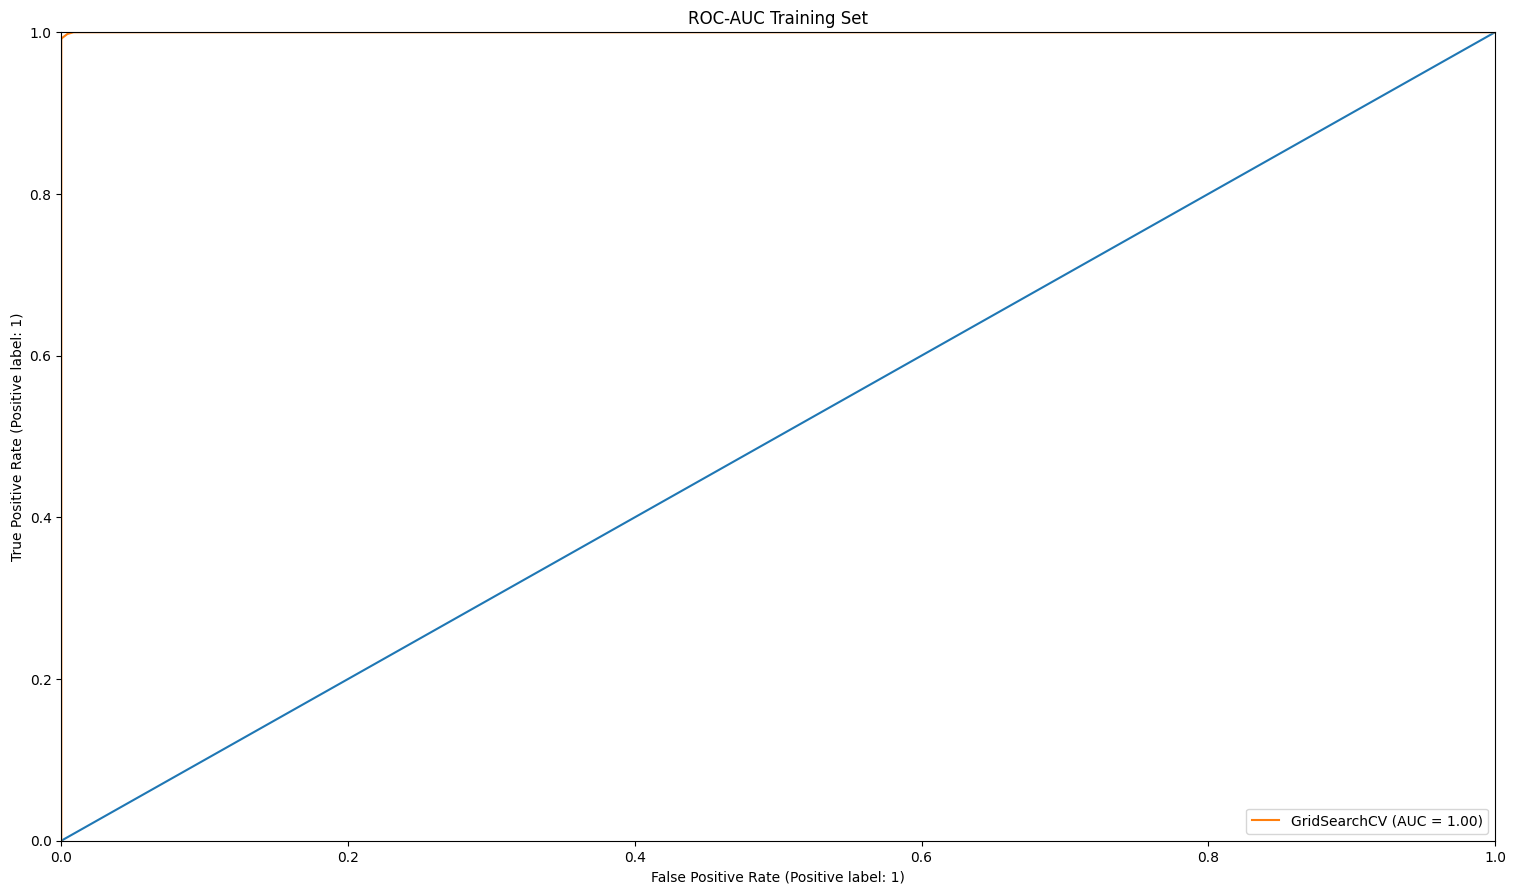

In [8]:
model_eval(knn_clf, x_train, y_train ,"knn2_rocauc")

In [1]:
def create_validation_knn(x, y, clf, key, values):
    train_scores_list, test_scores_list = [], []
    key2 = key.split("__")[1]
    
    params = clf.best_params_
    m_params = {}
    for k, v in clf.best_params_.items():
        m_params[k.split("__")[1]] = v
    del m_params[key2]    
    model = KNeighborsClassifier(**m_params)
    pipeline = Pipeline([
        ('bow', CountVectorizer()),
        ('knn', model),
    ]) 
    train_scores, test_scores = vc(
        estimator=pipeline,
        X=x,
        y=y,
        param_name=key,
        param_range=values,
        scoring="roc_auc",
        verbose=0    
    )
    train_scores_list.append(train_scores)
    test_scores_list.append(test_scores)
    
    return train_scores_list, test_scores_list

In [2]:
knn_train_scores_n_neighbors, knn_test_scores_n_neighbors = create_validation_knn(x_train, y_train, knn_clf, "knn__n_neighbors",  np.arange(3, 21, 1))

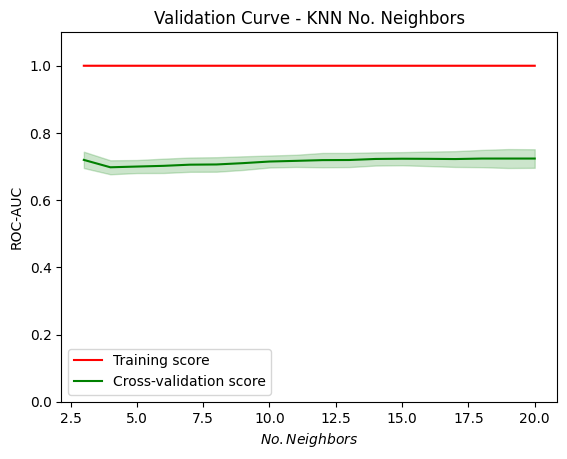

In [4]:
knn_train_scores_mean_n_neighbors = np.mean(knn_train_scores_n_neighbors[0], axis=1)
knn_train_scores_std_n_neighbors = np.std(knn_train_scores_n_neighbors[0], axis=1)
knn_test_scores_mean_n_neighbors = np.mean(knn_test_scores_n_neighbors[0], axis=1)
knn_test_scores_std_n_neighbors = np.std(knn_test_scores_n_neighbors[0], axis=1)
knn_param_range_n_neighbors = np.arange(3, 21, 1)

plt.title("Validation Curve - KNN No. Neighbors")
plt.xlabel("$No. Neighbors$")
plt.ylabel("ROC-AUC")
plt.ylim(0.0, 1.1)
plt.plot(knn_param_range_n_neighbors, knn_train_scores_mean_n_neighbors, label="Training score", color="r")
plt.fill_between(knn_param_range_n_neighbors, knn_train_scores_mean_n_neighbors - knn_train_scores_std_n_neighbors,
                 knn_train_scores_mean_n_neighbors + knn_train_scores_std_n_neighbors, alpha=0.2, color="r")
plt.plot(knn_param_range_n_neighbors, knn_test_scores_mean_n_neighbors, label="Cross-validation score",
             color="g")
plt.fill_between(knn_param_range_n_neighbors, knn_test_scores_mean_n_neighbors - knn_test_scores_std_n_neighbors,
                 knn_test_scores_mean_n_neighbors + knn_test_scores_std_n_neighbors, alpha=0.2, color="g")
plt.legend(loc="best")
plt.savefig("knn2_neighbors")

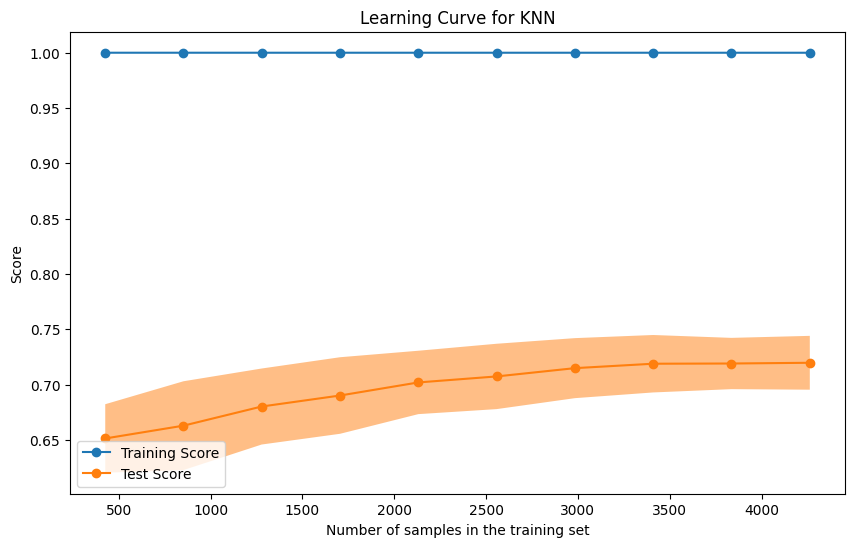

In [5]:
learning_curve(knn_clf.best_estimator_, "KNN")

# SVM Model

In [3]:
model = SVC(random_state=42, class_weight='balanced', probability=True)
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('svm', model),
])
parameters = {
    "svm__kernel" : ["rbf", "linear", "poly"],
    "svm__gamma": [0.1, 1, 10],
    "svm__C": [0.1, 1, 10],
    "svm__degree": [1, 2, 3, 4, 5]

}
skf = StratifiedKFold(n_splits=5)
svm_clf = GridSearchCV(pipeline, param_grid = parameters, cv = skf, scoring= 'roc_auc', verbose=3, n_jobs=-1, error_score='raise', return_train_score=True)
x_train_copy = x_train.copy()
x_train_copy.reset_index(drop=True, inplace=True)

x_train_sample = x_train_copy.sample(frac=0.05, random_state=42)
y_train_sample = y_train[x_train_sample.index]
svm_clf.fit(x_train_sample,y_train_sample)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
[CV 2/5] END svm__C=10, svm__degree=2, svm__gamma=1, svm__kernel=rbf;, score=(train=1.000, test=0.708) total time=   0.0s
[CV 2/5] END svm__C=10, svm__degree=2, svm__gamma=10, svm__kernel=poly;, score=(train=1.000, test=0.917) total time=   0.0s
[CV 3/5] END svm__C=10, svm__degree=2, svm__gamma=10, svm__kernel=poly;, score=(train=1.000, test=0.857) total time=   0.0s
[CV 4/5] END svm__C=10, svm__degree=2, svm__gamma=10, svm__kernel=poly;, score=(train=1.000, test=0.571) total time=   0.0s
[CV 5/5] END svm__C=10, svm__degree=2, svm__gamma=10, svm__kernel=poly;, score=(train=1.000, test=0.810) total time=   0.0s
[CV 1/5] END svm__C=10, svm__degree=3, svm__gamma=0.1, svm__kernel=rbf;, score=(train=1.000, test=0.917) total time=   0.1s
[CV 2/5] END svm__C=10, svm__degree=3, svm__gamma=0.1, svm__kernel=rbf;, score=(train=1.000, test=0.833) total time=   0.0s
[CV 3/5] END svm__C=10, svm__degree=3, svm__gamma=0.1, svm__kernel=rbf;

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             error_score='raise',
             estimator=Pipeline(steps=[('bow', CountVectorizer()),
                                       ('svm',
                                        SVC(class_weight='balanced',
                                            probability=True,
                                            random_state=42))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 10], 'svm__degree': [1, 2, 3, 4, 5],
                         'svm__gamma': [0.1, 1, 10],
                         'svm__kernel': ['rbf', 'linear', 'poly']},
             return_train_score=True, scoring='roc_auc', verbose=3)

Best score (CV score=0.747):
{'svm__C': 0.1, 'svm__degree': 3, 'svm__gamma': 0.1, 'svm__kernel': 'poly'}
Best Results: {'svm__C': 0.1, 'svm__degree': 3, 'svm__gamma': 0.1, 'svm__kernel': 'poly'}


mean_fit_time : 0.07065315246582031
std_fit_time : 0.0008672582491320198
mean_score_time : 0.007153511047363281
std_score_time : 0.0002727165900895965
param_svm__C : 0.1
param_svm__degree : 3
param_svm__gamma : 0.1
param_svm__kernel : poly
params : {'svm__C': 0.1, 'svm__degree': 3, 'svm__gamma': 0.1, 'svm__kernel': 'poly'}
split0_test_score : 0.8541374474053295
split1_test_score : 0.8519061583577712
split2_test_score : 0.6055718475073313
split3_test_score : 0.7260869565217392
split4_test_score : 0.6985507246376811
mean_test_score : 0.7472506268859704
std_test_score : 0.09515254133955922
rank_test_score : 1
split0_train_score : 1.0
split1_train_score : 1.0
split2_train_score : 1.0
split3_train_score : 1.0
split4_train_score : 1.0
mean_train_score : 1.0
std_train_score : 0.0
              preci

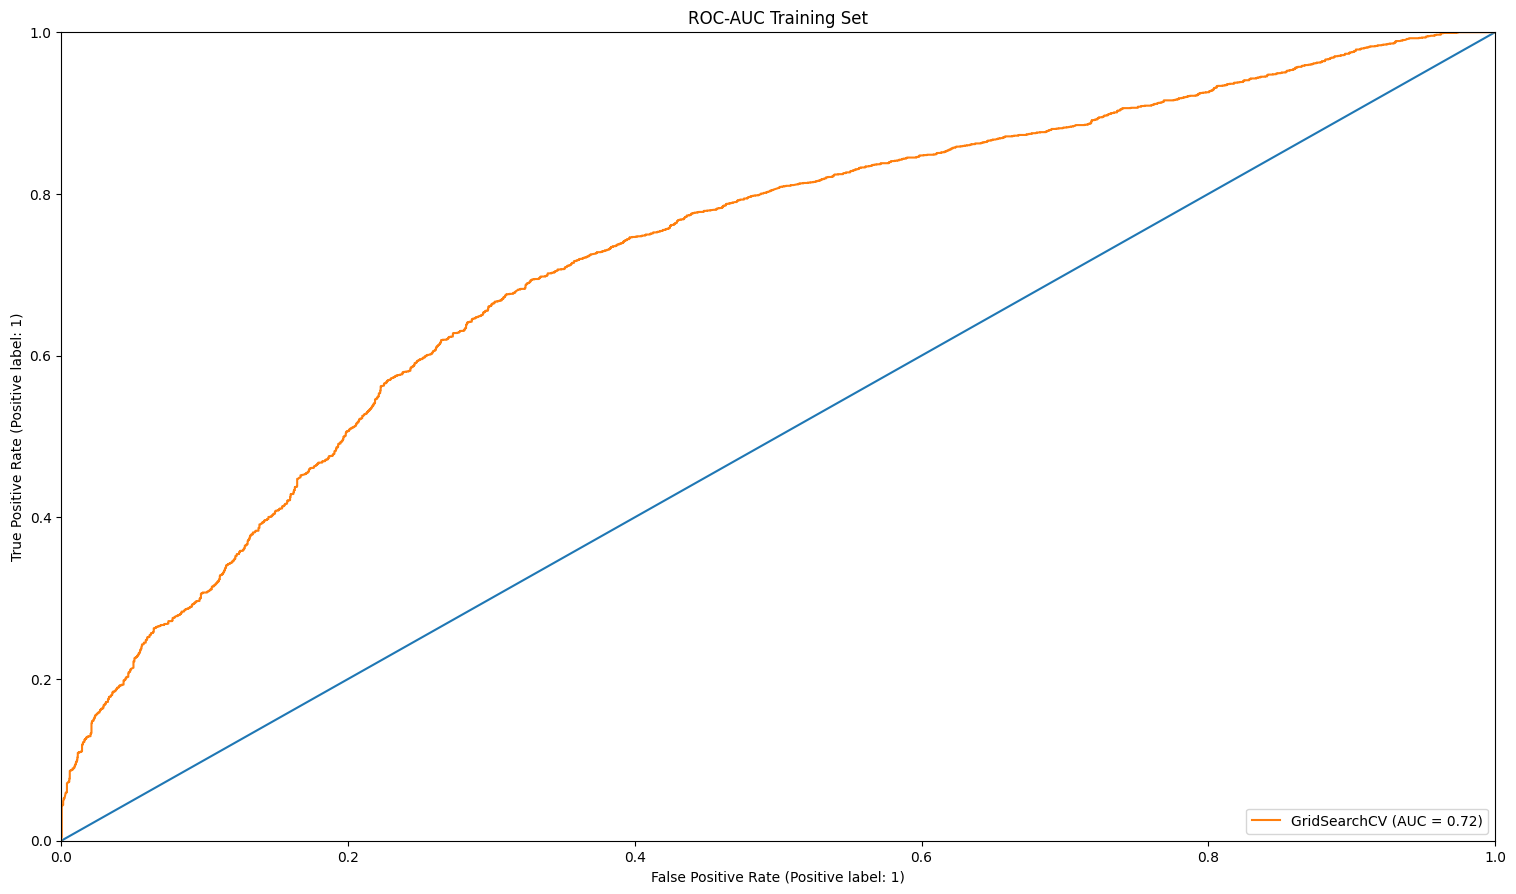

In [4]:
model_eval(svm_clf, x_train, y_train, "svm1_rocauc")

In [11]:
def create_validation_svm(x, y, clf, key, values):
    train_scores_list, test_scores_list = [], []
    key2 = key.split("__")[1]
    
    params = clf.best_params_
    m_params = {}
    for k, v in clf.best_params_.items():
        m_params[k.split("__")[1]] = v
    del m_params[key2]    
    model = SVC(random_state=42, class_weight='balanced', probability=True, **m_params)
    pipeline = Pipeline([
        ('bow', CountVectorizer()),
        ('svm', model),
    ]) 
    train_scores, test_scores = vc(
        estimator=pipeline,
        X=x,
        y=y,
        param_name=key,
        param_range=values,
        scoring="roc_auc",
        verbose=0    
    )
    train_scores_list.append(train_scores)
    test_scores_list.append(test_scores)
    
    return train_scores_list, test_scores_list

[CV 5/5] END svm__C=10, svm__degree=5, svm__gamma=0.1, svm__kernel=rbf;, score=(train=1.000, test=0.643) total time=   0.1s
[CV 1/5] END svm__C=10, svm__degree=5, svm__gamma=0.1, svm__kernel=linear;, score=(train=1.000, test=0.837) total time=   0.1s
[CV 3/5] END svm__C=10, svm__degree=5, svm__gamma=0.1, svm__kernel=poly;, score=(train=1.000, test=0.534) total time=   0.1s
[CV 4/5] END svm__C=10, svm__degree=5, svm__gamma=0.1, svm__kernel=poly;, score=(train=1.000, test=0.610) total time=   0.1s
[CV 1/5] END svm__C=10, svm__degree=5, svm__gamma=1, svm__kernel=linear;, score=(train=1.000, test=0.837) total time=   0.1s
[CV 2/5] END svm__C=10, svm__degree=5, svm__gamma=1, svm__kernel=linear;, score=(train=1.000, test=0.865) total time=   0.1s
[CV 2/5] END svm__C=10, svm__degree=5, svm__gamma=1, svm__kernel=poly;, score=(train=1.000, test=0.757) total time=   0.1s
[CV 3/5] END svm__C=10, svm__degree=5, svm__gamma=1, svm__kernel=poly;, score=(train=1.000, test=0.512) total time=   0.1s
[CV

### SVM Kernel

In [12]:
svm_train_scores_kernel, svm_test_scores_kernel = create_validation_svm(x_train, y_train, svm_clf, "svm__kernel",  ["rbf", "linear", "poly"])

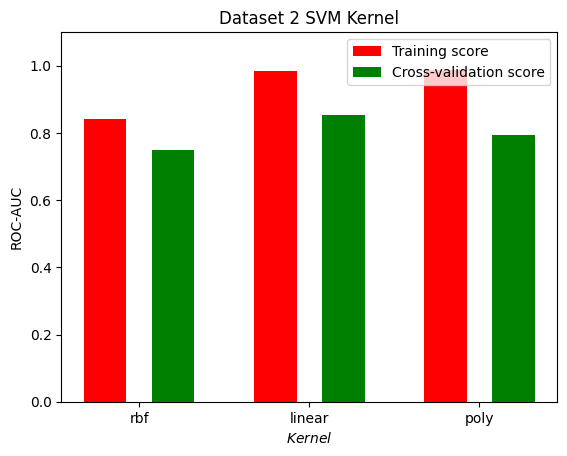

In [14]:
svm_train_scores_mean_kernel = np.mean(svm_train_scores_kernel[0], axis=1)
svm_train_scores_std_kernel = np.std(svm_train_scores_kernel[0], axis=1)
svm_test_scores_mean_kernel = np.mean(svm_test_scores_kernel[0], axis=1)
svm_test_scores_std_kernel = np.std(svm_test_scores_kernel[0], axis=1)
svm_param_range_kernel =  ["rbf", "linear", "poly"]

plt.title("Dataset 2 SVM Kernel")
plt.xlabel("$Kernel$")
plt.ylabel("ROC-AUC")
plt.ylim(0.0, 1.1)
width = 0.2
_X = np.arange(len(svm_param_range_kernel))
plt.bar(_X - width, svm_train_scores_mean_kernel, width=0.25, label="Training score", color="r")
plt.bar(_X + width, svm_test_scores_mean_kernel, width=0.25, label="Cross-validation score",
             color="g")
plt.legend(loc="best")
plt.xticks(_X, svm_param_range_kernel) # set labels manually
plt.savefig("svm2_kernel")

### SVM C

In [22]:
svm_train_scores_C, svm_test_scores_C = create_validation_svm(x_train, y_train, svm_clf, "svm__C", [0.1, 1, 10])

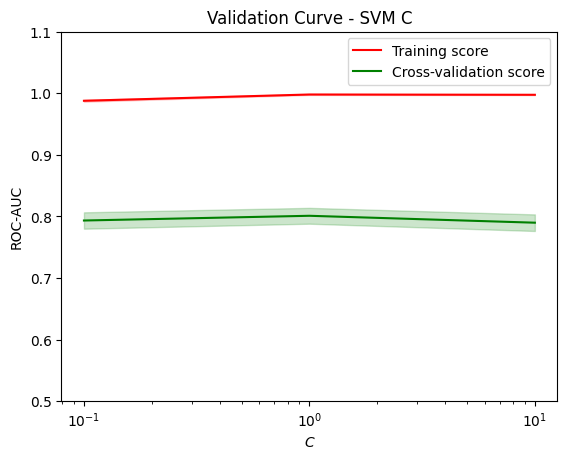

In [31]:
svm_train_scores_mean_C = np.mean(svm_train_scores_C[0], axis=1)
svm_train_scores_std_C = np.std(svm_train_scores_C[0], axis=1)
svm_test_scores_mean_C = np.mean(svm_test_scores_C[0], axis=1)
svm_test_scores_std_C = np.std(svm_test_scores_C[0], axis=1)
svm_param_range_C = [0.1, 1, 10]

plt.title("Validation Curve - SVM C")
plt.xlabel("$C$")
plt.ylabel("ROC-AUC")
plt.ylim(0.5, 1.1)
plt.semilogx(svm_param_range_C, svm_train_scores_mean_C, label="Training score", color="r")
plt.fill_between(svm_param_range_C, svm_train_scores_mean_C - svm_train_scores_std_C,
                 svm_train_scores_mean_C + svm_train_scores_std_C, alpha=0.2, color="r")
plt.semilogx(svm_param_range_C, svm_test_scores_mean_C, label="Cross-validation score",
             color="g")
plt.fill_between(svm_param_range_C, svm_test_scores_mean_C - svm_test_scores_std_C,
                 svm_test_scores_mean_C + svm_test_scores_std_C, alpha=0.2, color="g")
plt.legend(loc="best")
plt.savefig("svm2_C")

### SVM Gamma

In [24]:
svm_train_scores_gamma, svm_test_scores_gamma = create_validation_svm(x_train, y_train, svm_clf, "svm__gamma", [0.1, 1, 10])

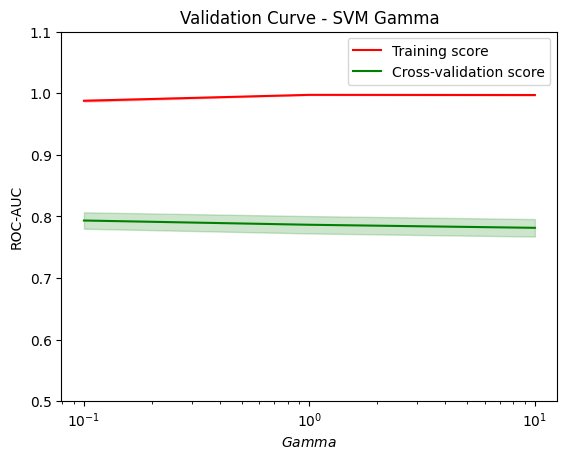

In [30]:
svm_train_scores_mean_gamma = np.mean(svm_train_scores_gamma[0], axis=1)
svm_train_scores_std_gamma = np.std(svm_train_scores_gamma[0], axis=1)
svm_test_scores_mean_gamma = np.mean(svm_test_scores_gamma[0], axis=1)
svm_test_scores_std_gamma = np.std(svm_test_scores_gamma[0], axis=1)
svm_param_range_gamma = [0.1, 1, 10]

plt.title("Validation Curve - SVM Gamma")
plt.xlabel("$Gamma$")
plt.ylabel("ROC-AUC")
plt.ylim(0.5, 1.1)
plt.semilogx(svm_param_range_gamma, svm_train_scores_mean_gamma, label="Training score", color="r")
plt.fill_between(svm_param_range_gamma, svm_train_scores_mean_gamma - svm_train_scores_std_gamma,
                 svm_train_scores_mean_gamma + svm_train_scores_std_gamma, alpha=0.2, color="r")
plt.semilogx(svm_param_range_gamma, svm_test_scores_mean_gamma, label="Cross-validation score",
             color="g")
plt.fill_between(svm_param_range_gamma, svm_test_scores_mean_gamma - svm_test_scores_std_gamma,
                 svm_test_scores_mean_gamma + svm_test_scores_std_gamma, alpha=0.2, color="g")
plt.legend(loc="best")
plt.savefig("svm2_gamma")

### SVM Degree

In [19]:
svm_train_scores_degree, svm_test_scores_degree = create_validation_svm(x_train, y_train, svm_clf, "svm__degree",  [1, 2, 3, 4, 5])

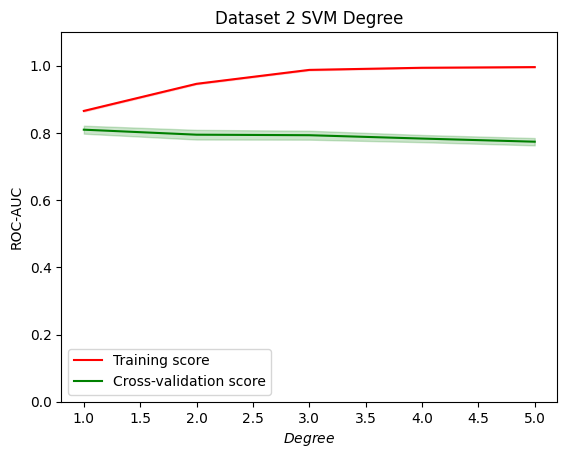

In [15]:
svm_train_scores_mean_degree = np.mean(svm_train_scores_degree[0], axis=1)
svm_train_scores_std_degree = np.std(svm_train_scores_degree[0], axis=1)
svm_test_scores_mean_degree = np.mean(svm_test_scores_degree[0], axis=1)
svm_test_scores_std_degree = np.std(svm_test_scores_degree[0], axis=1)
svm_param_range_degree = [1, 2, 3, 4, 5]

plt.title("Dataset 2 SVM Degree")
plt.xlabel("$Degree$")
plt.ylabel("ROC-AUC")
plt.ylim(0.0, 1.1)
plt.plot(svm_param_range_degree, svm_train_scores_mean_degree, label="Training score", color="r")
plt.fill_between(svm_param_range_degree, svm_train_scores_mean_degree - svm_train_scores_std_degree,
                 svm_train_scores_mean_degree + svm_train_scores_std_degree, alpha=0.2, color="r")
plt.plot(svm_param_range_degree, svm_test_scores_mean_degree, label="Cross-validation score",
             color="g")
plt.fill_between(svm_param_range_degree, svm_test_scores_mean_degree - svm_test_scores_std_degree,
                 svm_test_scores_mean_degree + svm_test_scores_std_degree, alpha=0.2, color="g")
plt.legend(loc="best")
plt.savefig("svm2_degree")

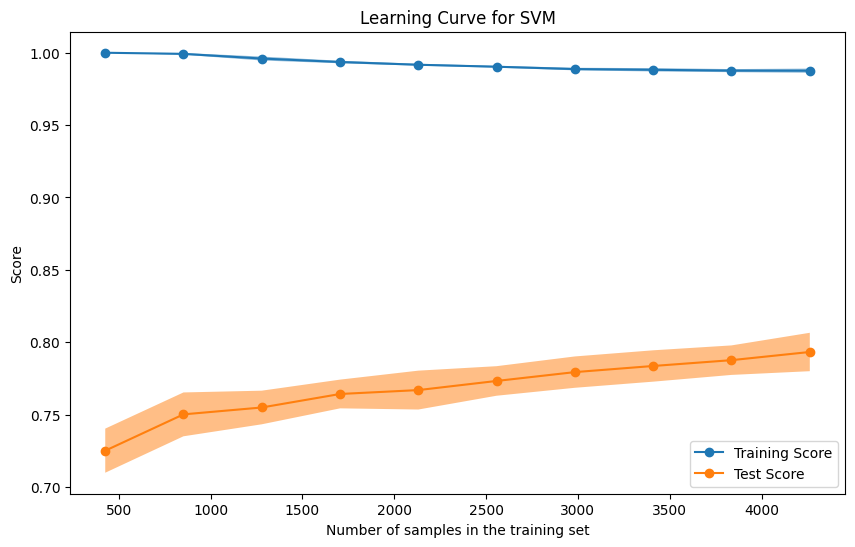

In [32]:
learning_curve(svm_clf.best_estimator_, "SVM")

# Test Set

In [5]:
from sklearn.metrics import roc_auc_score

In [7]:
params = {}
for k, v in xgboost_clf.best_params_.items():
    params[k.split("__")[1]] = v
model = XGBClassifier(scale_pos_weight=target_ratio, eval_metric='auc', seed=42, objective='binary:logistic', **params)
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('xgboost', model),
])
xgboost_model = pipeline.fit(x_train, y_train)


params = {}
for k, v in mlp_clf.best_params_.items():
    params[k.split("__")[1]] = v
model = MLPClassifier(max_iter=500, **params)
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('mlp', model),
])
mlp_model = pipeline.fit(x_train, y_train)

In [12]:
params = {}
for k, v in dt_clf.best_params_.items():
    params[k.split("__")[1]] = v
params["max_features"] = "sqrt"
model = model = DecisionTreeClassifier(class_weight='balanced', random_state=42, **params)
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('dt', model),
])
dt_model = pipeline.fit(x_train, y_train)

In [13]:
params = {}
for k, v in knn_clf.best_params_.items():
    params[k.split("__")[1]] = v
model = model = KNeighborsClassifier(**params)
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('knn', model),
])
knn_model = pipeline.fit(x_train, y_train)

In [15]:
params = {}
for k, v in svm_clf.best_params_.items():
    params[k.split("__")[1]] = v
model = model = SVC(random_state=42, class_weight='balanced', probability=True, **params)
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('svm', model),
])
svm_model = pipeline.fit(x_train, y_train)

In [13]:
xgboost_model.predict(x_test)
xgboost_rocauc_test = roc_auc_score(y_test, xgboost_model.predict_proba(x_test)[:, 1])
print(f"Xgboost: {xgboost_rocauc_test}")


mlp_model.predict(x_test)
mlp_rocauc_test = roc_auc_score(y_test, mlp_model.predict_proba(x_test)[:, 1])
print(f"MLP: {mlp_rocauc_test}")


dt_model.predict(x_test)
dt_rocauc_test = roc_auc_score(y_test, dt_model.predict_proba(x_test)[:, 1])
print(f"Decision Tree: {dt_rocauc_test}")


knn_model.predict(x_test)
knn_rocauc_test = roc_auc_score(y_test, knn_model.predict_proba(x_test)[:, 1])
print(f"KNN: {knn_rocauc_test}")

svm_model.predict(x_test)
svm_rocauc_test = roc_auc_score(y_test, svm_model.predict_proba(x_test)[:, 1])
print(f"SVM: {svm_rocauc_test}")

Xgboost: 0.8517621453823725
MLP: 0.844241274937551
Decision Tree: 0.7465920016773023
KNN: 0.7382727697315767
SVM: 0.7980399657968008
